In [34]:
# ==========================================
# 功能: 训练模型 + 保存 Loss + 保存 Node Embedding，用于可视化
# ==========================================

# ==========================================
# 1. 必要补丁
# ==========================================
import sys
import os
import networkx as nx
import pickle

# 修复 NetworkX 3.x 兼容性
if not hasattr(nx, 'from_numpy_matrix'):
    print("[Patch] 修复 NetworkX from_numpy_matrix ...")
    nx.from_numpy_matrix = nx.from_numpy_array

# 修复 RDKit six 兼容性
try:
    import six
    import rdkit
    if not hasattr(rdkit, 'six'):
        print("[Patch] 修复 RDKit.six ...")
        rdkit.six = six
        sys.modules['rdkit.six'] = six
except ImportError:
    pass

# ==========================================
# 2. 导入库
# ==========================================
import json
import time
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from model import GraphFlowModel
from dataloader import PretrainZinkDataset
import utils

# 设置随机种子
utils.set_seed(2019, torch.cuda.is_available())

# ==========================================
# 3. 配置类
# ==========================================
class Config:
    dataset = 'dataset3'
    path = 'data_preprocessed/dataset3'
    
    batch_size = 32
    edge_unroll = 12
    shuffle = True
    num_workers = 0  # Notebook 中必须为 0

    name = 'dataset3_model'
    deq_type = 'random'
    deq_coeff = 0.9
    num_flow_layer = 6
    gcn_layer = 3
    nhid = 128
    nout = 128
    st_type = 'sigmoid'
    sigmoid_shift = 2.0

    train = True
    save = True
    all_save_prefix = './'
    no_cuda = False
    learn_prior = False
    seed = 2019
    epochs = 5
    lr = 0.001
    weight_decay = 0.0
    dropout = 0.0
    is_bn = False
    is_bn_before = False
    scale_weight_norm = False
    divide_loss = False
    init_checkpoint = None
    show_loss_step = 100

    gen = True 
    gen_num = 1000
    gen_out_path = 'generated_dataset3.txt'
    temperature = 0.75
    min_atoms = 5

    max_atoms = 48  # 会在读取数据后自动更新

    @property
    def cuda(self):
        return not self.no_cuda and torch.cuda.is_available()
    
    @property
    def save_path(self):
        dir_path = os.path.join(self.all_save_prefix, 'save_pretrain', f'{self.st_type}_{self.dataset}_{self.name}')
        if self.save and not os.path.exists(dir_path):
            os.makedirs(dir_path)
        return dir_path

args = Config()

# ==========================================
# 4. 读取数据与保存函数
# ==========================================
def save_model(model, optimizer, args, var_list, epoch=None):
    config_dict = {k: v for k, v in args.__class__.__dict__.items() if not k.startswith('__') and not isinstance(v, property)}
    with open(os.path.join(args.save_path, 'config.json'), 'w') as f:
        json.dump(str(config_dict), f)

    epoch_str = str(epoch) if epoch is not None else ''
    path = os.path.join(args.save_path, f'checkpoint{epoch_str}')
    
    torch.save({
        **var_list,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()},
        path
    )
    print(f"模型已保存至: {path}")

def read_molecules(path):
    print(f'📥 Reading data from {path}...')
    if not os.path.exists(path + '_config.txt'):
        raise FileNotFoundError(f"找不到配置文件: {path}_config.txt")

    node_features = np.load(path + '_node_features.npy')
    adj_features = np.load(path + '_adj_features.npy')
    mol_sizes = np.load(path + '_mol_sizes.npy')

    with open(path + '_config.txt', 'r') as f:
        data_config = eval(f.read())

    all_smiles = []  # 可选，用于去重
    return node_features, adj_features, mol_sizes, data_config, all_smiles

# ==========================================
# 5. 训练器类
# ==========================================
class Trainer(object):
    def __init__(self, dataloader, data_config, args, all_train_smiles=None):
        self.dataloader = dataloader
        self.data_config = data_config
        self.args = args
        self.all_train_smiles = all_train_smiles

        self.max_size = self.data_config['max_size']
        self.node_dim = self.data_config['node_dim'] - 1
        self.bond_dim = self.data_config['bond_dim']

        print(f"初始化模型: Max Atoms={self.max_size}, Node Dim={self.node_dim}")
        self._model = GraphFlowModel(self.max_size, self.node_dim, self.bond_dim, self.args.edge_unroll, self.args)
        self._optimizer = optim.Adam(filter(lambda p: p.requires_grad, self._model.parameters()),
                                     lr=self.args.lr, weight_decay=self.args.weight_decay)

        self.best_loss = 100.0
        self.start_epoch = 0
        self.loss_history = []

        if self.args.cuda:
            self._model = self._model.cuda()

    # ==========================================
    # 生成分子
    # ==========================================
    def generate_molecules(self, num=None, out_path=None):
        if num is None:
            num = getattr(self.args, 'gen_num', 100)
        if out_path is None:
            out_path = getattr(self.args, 'gen_out_path', 'generated_dataset3.txt')

        self._model.eval()
        all_smiles = []
        cnt_mol = 0
        cnt_gen = 0
        print(f"Generating {num} molecules ...")

        while cnt_mol < num:
            smiles, _, num_atoms = self._model.generate(
                temperature=getattr(self.args, 'temperature', 0.75),
                mute=True,
                max_atoms=self.max_size,
                cnt=cnt_gen
            )
            cnt_gen += 1
            if num_atoms >= getattr(self.args, 'min_atoms', 5):
                all_smiles.append(smiles)
                cnt_mol += 1
                if cnt_mol % 20 == 0:
                    print(f' Generated: {cnt_mol}/{num}')

        # 保存生成分子
        with open(out_path, 'w') as f:
            for smi in all_smiles:
                f.write(smi + '\n')
        print(f"Molecules saved to {out_path}")

    def train_epoch(self, epoch_cnt):
        t_start = time.time()
        batch_losses = []
        self._model.train()

        for i_batch, batch_data in enumerate(self.dataloader):
            self._optimizer.zero_grad()
            
            inp_node_features = batch_data['node']
            inp_adj_features = batch_data['adj']

            if self.args.cuda:
                inp_node_features = inp_node_features.cuda()
                inp_adj_features = inp_adj_features.cuda()

            # Forward
            if self.args.deq_type == 'random':
                out_z, out_logdet, ln_var = self._model(inp_node_features, inp_adj_features)
                loss = self._model.log_prob(out_z, out_logdet)
            elif self.args.deq_type == 'variational':
                out_z, out_logdet, out_deq_logp, out_deq_logdet = self._model(inp_node_features, inp_adj_features)
                ll_node, ll_edge, ll_deq_node, ll_deq_edge = self._model.log_prob(out_z, out_logdet, out_deq_logp, out_deq_logdet)
                loss = -1. * ((ll_node-ll_deq_node) + (ll_edge-ll_deq_edge))
            else:
                raise ValueError('unsupported dequantization method')

            loss.backward()
            self._optimizer.step()
            batch_losses.append(loss.item())
            self.loss_history.append(loss.item())

            if (i_batch + 1) % self.args.show_loss_step == 0:
                print(f'   Step: {i_batch + 1} | Loss: {loss.item():.5f}')

        epoch_loss = sum(batch_losses) / len(batch_losses)
        print(f'Epoch: {epoch_cnt} | Avg Loss: {epoch_loss:.5f} | Time: {time.time()-t_start:.2f}s')
        return epoch_loss

    def save_embeddings(self, save_dir=None):
        """ 保存 Node Embedding 用于可视化 (支持不同节点数的分子) """
        if save_dir is None:
            save_dir = os.path.join(self.args.save_path, 'node_embeddings')
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        self._model.eval()
        print("🔍 Extracting node embeddings batch by batch...")
        import pickle
        with torch.no_grad():
            for i_batch, batch_data in enumerate(self.dataloader):
                x = batch_data['node']
                adj = batch_data['adj']
                if self.args.cuda:
                    x, adj = x.cuda(), adj.cuda()

                ret = self._model(x, adj)
                out_z = ret[0] if isinstance(ret, tuple) else ret

                # 每个图节点数不同，保持列表结构
                batch_emb = [emb.cpu().numpy() for emb in out_z]

                save_path = os.path.join(save_dir, f'batch_{i_batch}.pkl')
                with open(save_path, 'wb') as f:
                    pickle.dump(batch_emb, f)

        print(f"All batch embeddings saved in {save_dir}")



    def fit(self):
        print('开始训练...')
        for epoch in range(self.args.epochs):
            cur_epoch = epoch + self.start_epoch
            epoch_loss = self.train_epoch(cur_epoch)

            if epoch_loss < self.best_loss:
                self.best_loss = epoch_loss
                if self.args.save:
                    var_list = {'cur_epoch': cur_epoch, 'best_loss': self.best_loss, 'loss_history': self.loss_history}
                    save_model(self._model, self._optimizer, self.args, var_list, epoch=cur_epoch)

        print("训练完成!")

# ==========================================
# 6. 主执行流程
# ==========================================
if __name__ == '__main__':
    # 1. 读取数据
    node_features, adj_features, mol_sizes, data_config, all_smiles = read_molecules(args.path)
    args.max_atoms = data_config['max_size']
    print(f"📊 Dataset Info: {node_features.shape}, Max Atoms: {args.max_atoms}")

    # 2. 构建 DataLoader
    train_dataset = PretrainZinkDataset(node_features, adj_features, mol_sizes)
    train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size,
                                  shuffle=args.shuffle, num_workers=args.num_workers)

    # 3. 初始化 Trainer
    trainer = Trainer(train_dataloader, data_config, args, all_train_smiles=all_smiles)

    # 4. 训练
    if args.train:
        trainer.fit()
        # 保存 Node Embedding
        trainer.save_embeddings(save_dir=os.path.join(args.save_path, 'node_embeddings'))
        # 保存 loss
        np.save(os.path.join(args.save_path, 'loss_history.npy'), np.array(trainer.loss_history))
        print("Embeddings + Loss 已保存")

    # 5. 生成分子 (如果 args.gen=True)
    if getattr(args, 'gen', True):
        trainer.generate_molecules()


set seed for random numpy and torch
📥 Reading data from data_preprocessed/dataset3...
📊 Dataset Info: (10000, 48), Max Atoms: 48
🏗️ 初始化模型: Max Atoms=48, Node Dim=12
latent node length: 576
latent edge length: 1992
using 1 GPUs
🚀 开始训练...
   Step: 100 | Loss: 3875.23047
   Step: 200 | Loss: 3280.07617
   Step: 300 | Loss: 3165.52246
Epoch: 0 | Avg Loss: 3761.39518 | Time: 26.10s
🎉 训练完成!
🔍 Extracting node embeddings batch by batch...
📂 All batch embeddings saved in ./save_pretrain/sigmoid_dataset3_dataset3_model/node_embeddings
📈 Embeddings + Loss 已保存
🧪 Generating 10 molecules ...


[16:36:04] Explicit valence for atom # 0 C, 5, is greater than permitted
[16:36:04] Explicit valence for atom # 0 C, 5, is greater than permitted
[16:36:04] Explicit valence for atom # 0 O, 3, is greater than permitted
[16:36:04] Explicit valence for atom # 2 Br, 2, is greater than permitted
[16:36:04] Explicit valence for atom # 2 Br, 3, is greater than permitted
[16:36:04] Explicit valence for atom # 2 Br, 2, is greater than permitted
[16:36:04] Explicit valence for atom # 2 Br, 2, is greater than permitted
[16:36:04] Explicit valence for atom # 2 Br, 2, is greater than permitted
[16:36:04] Explicit valence for atom # 2 Br, 2, is greater than permitted
[16:36:04] Explicit valence for atom # 2 Br, 3, is greater than permitted
[16:36:04] Explicit valence for atom # 2 Br, 2, is greater than permitted
[16:36:04] Explicit valence for atom # 2 Br, 2, is greater than permitted
[16:36:04] Explicit valence for atom # 0 Br, 3, is greater than permitted
[16:36:04] Explicit valence for atom # 0 

📄 Molecules saved to generated_dataset3.txt


🔹 总节点 embedding 数量: 61458
最大节点 embedding 维度: 1992
🔹 分子 embedding shape: (61458, 1992)
🔹 PCA 降维后 shape: (61458, 50)
🔹 t-SNE 完成


/root/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/root/miniconda3/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


🔹 UMAP 完成


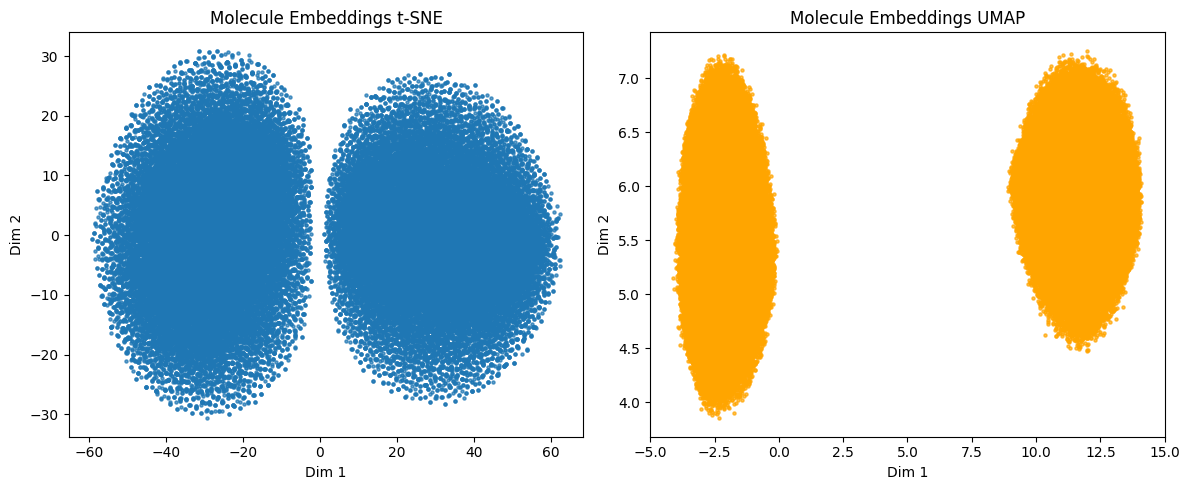

📂 可视化结果已保存至: ./save_pretrain/sigmoid_dataset3_dataset3_model/embedding_visual.png


In [1]:
# ==========================================
# visualize_embeddings.py
# 功能: 可视化训练保存的 Node Embedding（支持不同节点数的分子）
# ==========================================
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
try:
    import umap
except ImportError:
    print("⚠️ 未安装 UMAP，请执行: pip install umap-learn")

# =========================
# 1. 配置
# =========================
save_path = './save_pretrain/sigmoid_dataset3_dataset3_model'  # 与训练一致
embedding_dir = os.path.join(save_path, 'node_embeddings')
visual_out_path = os.path.join(save_path, 'embedding_visual.png')

# =========================
# 2. 读取所有分子节点 embedding
# =========================
all_embeddings = []
files = sorted([f for f in os.listdir(embedding_dir) if f.endswith('.pkl')])

for f in files:
    file_path = os.path.join(embedding_dir, f)
    with open(file_path, 'rb') as fin:
        batch_emb = pickle.load(fin)  # list of [num_nodes, node_dim]
        all_embeddings.extend(batch_emb)

print(f"🔹 总节点 embedding 数量: {len(all_embeddings)}")

# =========================
# 3. 将节点 embedding 转分子 embedding（节点均值 + 统一维度）
# =========================
mol_embeddings = []
max_dim = max([emb.shape[1] for emb in all_embeddings if len(emb) > 0])
print(f"最大节点 embedding 维度: {max_dim}")

for emb in all_embeddings:
    if len(emb) == 0:
        mol_emb = np.zeros(max_dim)
    else:
        node_emb = np.mean(emb, axis=0)  # 节点均值
        # padding 或截断
        if len(node_emb) < max_dim:
            mol_emb = np.pad(node_emb, (0, max_dim - len(node_emb)))
        else:
            mol_emb = node_emb[:max_dim]
    mol_embeddings.append(mol_emb)

mol_embeddings = np.array(mol_embeddings)
print(f"🔹 分子 embedding shape: {mol_embeddings.shape}")  # [num_molecules, max_dim]

# =========================
# 4. 降维可视化 (PCA -> t-SNE -> UMAP)
# =========================
# PCA 降到 50 维，给 t-SNE / UMAP 提速
pca = PCA(n_components=min(50, mol_embeddings.shape[1]))
mol_embeddings_pca = pca.fit_transform(mol_embeddings)
print(f"🔹 PCA 降维后 shape: {mol_embeddings_pca.shape}")

# t-SNE 可视化
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
mol_tsne = tsne.fit_transform(mol_embeddings_pca)
print("🔹 t-SNE 完成")

# UMAP 可视化（如果安装了 umap-learn）
try:
    umap_model = umap.UMAP(n_components=2, random_state=42)
    mol_umap = umap_model.fit_transform(mol_embeddings_pca)
    print("🔹 UMAP 完成")
except:
    mol_umap = None

# =========================
# 5. 绘图
# =========================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(mol_tsne[:, 0], mol_tsne[:, 1], s=5, alpha=0.7)
plt.title('Molecule Embeddings t-SNE')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')

if mol_umap is not None:
    plt.subplot(1, 2, 2)
    plt.scatter(mol_umap[:, 0], mol_umap[:, 1], s=5, alpha=0.7, color='orange')
    plt.title('Molecule Embeddings UMAP')
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')

plt.tight_layout()
plt.savefig(visual_out_path, dpi=300)
plt.show()
print(f"📂 可视化结果已保存至: {visual_out_path}")


In [82]:
# 运行5个Epoch, 生成1000个分子的质量评估
import os
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random

# RDKit imports
from rdkit import Chem
from rdkit.Chem import Descriptors, QED, AllChem
from rdkit.DataStructs import TanimotoSimilarity
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator 

try:
    # 使用 radius=2 创建 Morgan Generator (ECFP4)
    FP_GEN = GetMorganGenerator(radius=2) 
except Exception as e:
    # 如果初始化失败，使用 None 并在 get_fingerprints 中使用旧方法
    print(f"Error initializing MorganGenerator: {e}. Falling back to deprecated function.")
    FP_GEN = None 
    

class EVAL_SETTINGS:
    """评估性能优化设置"""
    # [INTERNAL DIVERSITY REMOVED] 移除了 SAMPLE_LIMIT_DIVERSITY
    
    # 启用此项将跳过 O(N_gen * N_train) 复杂度的训练集平均相似度计算。
    SKIP_TRAIN_SIMILARITY = True 
    
    
# --- 核心辅助函数：计算指纹和相似度 ---

def get_fingerprints(mols):
    """为分子列表生成 ECFP4 指纹 (Morgan Fingerprints)。"""
    if not mols:
        return []
        
    # 🌟 MODIFICATION 3: 使用 FP_GEN 实例进行指纹计算
    if FP_GEN:
        return [FP_GEN.GetFingerprint(m) for m in mols]
    else:
        # 兼容旧 RDKit 版本或初始化失败的情况
        return [AllChem.GetMorganFingerprint(m, 2) for m in mols]

# [INTERNAL DIVERSITY REMOVED] 移除了 calculate_internal_diversity 函数

def calculate_novelty_similarity(unique_fps, train_fps):
    """计算生成分子与训练集之间的 Tanimoto 相似度。"""
    if not unique_fps or not train_fps:
        return np.nan
    
    if EVAL_SETTINGS.SKIP_TRAIN_SIMILARITY:
        print("   🌐 Skipping training set similarity calculation (O(N_gen * N_train) complexity).")
        return np.nan
        
    print("   🌐 Calculating average nearest neighbor similarity to training set (long process)...")
    nearest_similarities = []
    
    # 提示：此循环效率极低，如果训练集过大，即使是 1000 个生成分子也会很慢。
    for gen_fp in unique_fps:
        # TanimotoSimilarity 接受单个指纹和指纹列表
        similarities = TanimotoSimilarity(gen_fp, train_fps)
        if similarities:
            nearest_similarities.append(max(similarities))
        
    # 返回平均的最近邻相似度
    return np.mean(nearest_similarities)


# --- 评估主函数 ---

def evaluate_generated_molecules(file_path, train_data_path=None, plot_output_dir='./plots'):
    """
    评估生成分子的质量，并绘制可视化图表。
    :param file_path: 生成的 SMILES 文件路径。
    :param train_data_path: 训练集 SMILES 文件路径（用于计算新颖性）。
    :param plot_output_dir: 图像保存路径。
    """
    print(f"🕵️‍♂️ Evaluating file: {file_path} ...")
    
    if not os.path.exists(file_path):
        print(f"❌ ERROR: File {file_path} not found. Please run generation code first.")
        return

    # 1. 读取生成的 SMILES
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    
    total_generated = len(lines)
    if total_generated == 0:
        print("⚠️ File is empty.")
        return

    # 2. 检查合法性 (Validity)
    valid_mols = []
    valid_smiles = []
    for smi in lines:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            valid_mols.append(mol)
            valid_smiles.append(smi)
            
    validity = len(valid_mols) / total_generated

    # 3. 检查唯一性 (Uniqueness) 和指纹 (Fingerprints)
    canonical_smiles_map = {}
    for m in valid_mols:
        smi = Chem.MolToSmiles(m)
        if smi not in canonical_smiles_map:
            canonical_smiles_map[smi] = m
            
    unique_smiles = list(canonical_smiles_map.keys())
    unique_mols = list(canonical_smiles_map.values())
    
    uniqueness = len(unique_smiles) / len(valid_mols) if len(valid_mols) > 0 else 0.0

    # 4. 指纹计算 (用于相似性)
    unique_fps = get_fingerprints(unique_mols)
    
    # 5. [INTERNAL DIVERSITY REMOVED] 移除了内部多样性计算的调用
    # 6. 计算新颖性 (Novelty) & 训练集相似度
    novelty = 0.0
    avg_sim_train = np.nan
    train_fps = []
    
    if train_data_path and os.path.exists(train_data_path):
        print("   Loading training set for novelty calculation...")
        train_smiles_set = set()
        train_mols = []
        with open(train_data_path, 'r') as f:
            for line in f:
                s = line.strip()
                if s and 'smile' not in s.lower():
                    train_smiles_set.add(s)
                    m = Chem.MolFromSmiles(s)
                    if m is not None:
                        train_mols.append(m)
        
        train_fps = get_fingerprints(train_mols)
        
        # 计算不在训练集中的独特分子数量
        new_mols_count = len([smi for smi in unique_smiles if smi not in train_smiles_set])
        novelty = new_mols_count / len(unique_smiles) if len(unique_smiles) > 0 else 0.0
        
        # 计算平均最近邻相似度
        if unique_fps and train_fps:
            avg_sim_train = calculate_novelty_similarity(unique_fps, train_fps)


    # 7. 计算化学属性 (QED, LogP, SA Score, MW)
    if len(valid_mols) > 0:
        # 只在唯一分子上计算属性，以避免重复计算和分布偏差
        qed_scores = [QED.qed(m) for m in unique_mols]
        logp_scores = [Descriptors.MolLogP(m) for m in unique_mols]
        # [SA SCORE REMOVED] 移除了 sa_scores 的计算
        mw_scores = [Descriptors.MolWt(m) for m in unique_mols]
        
        avg_qed = np.nanmean(qed_scores)
        avg_logp = np.nanmean(logp_scores)
        # [SA SCORE REMOVED] 移除了 avg_sa 的定义
        avg_mw = np.nanmean(mw_scores)
        
        # 为绘图占位 (必须保证数据列表存在)
        sa_scores = [np.nan] * len(unique_mols)
    else:
        qed_scores, logp_scores, mw_scores, sa_scores = [], [], [], []
        avg_qed, avg_logp, avg_mw = 0.0, 0.0, 0.0


    # === 可视化报告 ===
    
    if not os.path.exists(plot_output_dir):
        os.makedirs(plot_output_dir)
        print(f"   Creating plot output directory: {plot_output_dir}")
        
    # 绘制 QED, LogP, MW 的直方图
    data_to_plot = {
        "QED Score Distribution": (qed_scores, 'QED Score', 'blue'),
        "LogP Score Distribution": (logp_scores, 'LogP Score', 'green'),
        "Molecular Weight Distribution": (mw_scores, 'Molecular Weight (Daltons)', 'purple')
    }
    
    for title, (data, xlabel, color) in data_to_plot.items():
        # 仅在数据有效时绘图
        if data and not np.all(np.isnan(data)):
            plt.figure(figsize=(8, 6))
            # 自动调整 bins 数量，如果数据范围很小，确保 bin 大于 0
            bins = max(5, int(np.sqrt(len(data)))) 
            plt.hist(data, bins=bins, color=color, alpha=0.7, edgecolor='black')
            # 🌟 MODIFICATION: Title to English
            plt.title(f'{title} ({len(data)} Unique Molecules)', fontsize=16) 
            plt.xlabel(xlabel, fontsize=12)
            # 🌟 MODIFICATION: Y-label to English
            plt.ylabel('Frequency', fontsize=12) 
            plt.grid(axis='y', alpha=0.5)
            plt.savefig(os.path.join(plot_output_dir, f'{xlabel.replace(" ", "_")}_histogram.png'))
            plt.close()

    # 绘制 QED vs LogP 散点图 (不再着色)
    if len(qed_scores) > 0 and len(logp_scores) > 0:
        plt.figure(figsize=(10, 8))
        
        # [SA SCORE REMOVED] 散点图不再使用 SA Score 进行着色
        plt.scatter(logp_scores, qed_scores, color='blue', alpha=0.7, s=50)
        
        # 🌟 MODIFICATION: Title to English (简化标题，因无颜色编码)
        plt.title('QED vs LogP', fontsize=16) 
        plt.xlabel('LogP (Lipophilicity)', fontsize=12) # 🌟 MODIFICATION: X-label to English
        plt.ylabel('QED (Drug Likeness)', fontsize=12) # 🌟 MODIFICATION: Y-label to English
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.savefig(os.path.join(plot_output_dir, 'QED_vs_LogP_scatter.png'))
        plt.close()

    # === 打印最终报告 (输出保持中文，因为它在控制台显示) ===
    print("\n" + "="*60)
    print(f"📊 增强生成结果评估报告")
    print("="*60)
    print(f"生成总数 (Total Generated):        {total_generated}")
    print(f"合法分子 (Valid Molecules):        {len(valid_mols)}")
    print(f"唯一合法分子 (Unique Valid):      {len(unique_mols)}")
    print("-" * 60)
    print(f"✅ 合法率 (Validity):            {validity:.2%}")
    print(f"💎 唯一率 (Uniqueness Rate):      {uniqueness:.2%}")
    
    if train_data_path:
        print(f"✨ 新颖性 (Novelty):            {novelty:.2%}")
        if not EVAL_SETTINGS.SKIP_TRAIN_SIMILARITY:
            print(f"🌐 训练集平均相似度:           {avg_sim_train:.4f} (Avg Tanimoto to nearest neighbor)")
        else:
            print("🌐 训练集相似度计算已跳过 (EVAL_SETTINGS.SKIP_TRAIN_SIMILARITY = True)")

    print("-" * 60)
    print(f"平均 QED (药物相似性):         {avg_qed:.4f}")
    print(f"平均 LogP (脂溶性):           {avg_logp:.4f}")
    # [SA SCORE REMOVED] 移除了 SA Score 的控制台输出
    print(f"平均分子量 (Average MW):       {avg_mw:.2f} Da")
    print("="*60)
    
    # 展示前几个合法的分子
    if len(unique_smiles) > 0:
        print(f"\n🧪 示例生成分子 (共 {len(unique_smiles)} 种独特结构):")
        for i in range(min(5, len(unique_smiles))):
            smi = unique_smiles[i]
            mol = Chem.MolFromSmiles(smi)
            # [SA SCORE REMOVED] 移除了示例分子的 SA Score 输出
            print(f"  {i+1}. {smi} (QED: {QED.qed(mol):.3f})")

# ================= 执行评估 =================

if __name__ == '__main__':
    # 1. 指定生成的文件路径 (根据你之前的 Config 设置)
    generated_file = 'generated_dataset3_2.txt' 

    # 2. 指定训练集路径 (用于计算新颖性，可选)
    # 只有一列 SMILES
    train_file = 'dataset3.csv' 
    
    # 3. 运行评估
    # 图像会保存在当前目录下的 ./plots 文件夹中
    evaluate_generated_molecules(generated_file, train_file)

🕵️‍♂️ Evaluating file: generated_dataset3_2.txt ...
   Loading training set for novelty calculation...


[20:10:14] SMILES Parse Error: syntax error while parsing: 0
[20:10:14] SMILES Parse Error: Failed parsing SMILES '0' for input: '0'


   🌐 Skipping training set similarity calculation (O(N_gen * N_train) complexity).

📊 增强生成结果评估报告
生成总数 (Total Generated):        1000
合法分子 (Valid Molecules):        1000
唯一合法分子 (Unique Valid):      970
------------------------------------------------------------
✅ 合法率 (Validity):            100.00%
💎 唯一率 (Uniqueness Rate):      97.00%
✨ 新颖性 (Novelty):            95.98%
🌐 训练集相似度计算已跳过 (EVAL_SETTINGS.SKIP_TRAIN_SIMILARITY = True)
------------------------------------------------------------
平均 QED (药物相似性):         0.4601
平均 LogP (脂溶性):           2.4049
平均分子量 (Average MW):       315.17 Da

🧪 示例生成分子 (共 970 种独特结构):
  1. COc1ccc(B(O)O)cc1O (QED: 0.499)
  2. CC1C[Se]C(=O)N(C(=O)CN2C(I)=CC=C(F)N=C2Cl)C1 (QED: 0.340)
  3. ClC1=CC=C[Se]C(Cl)=C1Br (QED: 0.603)
  4. Oc1ccc(Br)c(I)n1 (QED: 0.588)
  5. CC#[Si]C#CCCCNC (QED: 0.354)


🔍 读取 Embedding 文件: ./save_pretrain/sigmoid_dataset3_dataset3_model/node_embeddings
🔹 加载了 61458 个分子的 Embedding
🔹 单个分子 Embedding 原始形状: (32, 576), 展平后维度: 18432


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

🔹 最终矩阵 Shape: (30728, 18432) (Samples, Features)

🔥 正在计算相关性热力图 (Disentanglement Analysis)...


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

✅ 热力图已保存: ./save_pretrain/sigmoid_dataset3_dataset3_model/analysis_results/correlation_heatmap.png
   (解读: 理想的流模型应呈现清晰的对角线，非对角区域接近白色/0)

🌌 正在计算降维可视化 (Latent Space Visualization)...
   PCA 降维完成: (30728, 50)
   正在运行 t-SNE ...
   正在运行 UMAP ...


/root/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were f

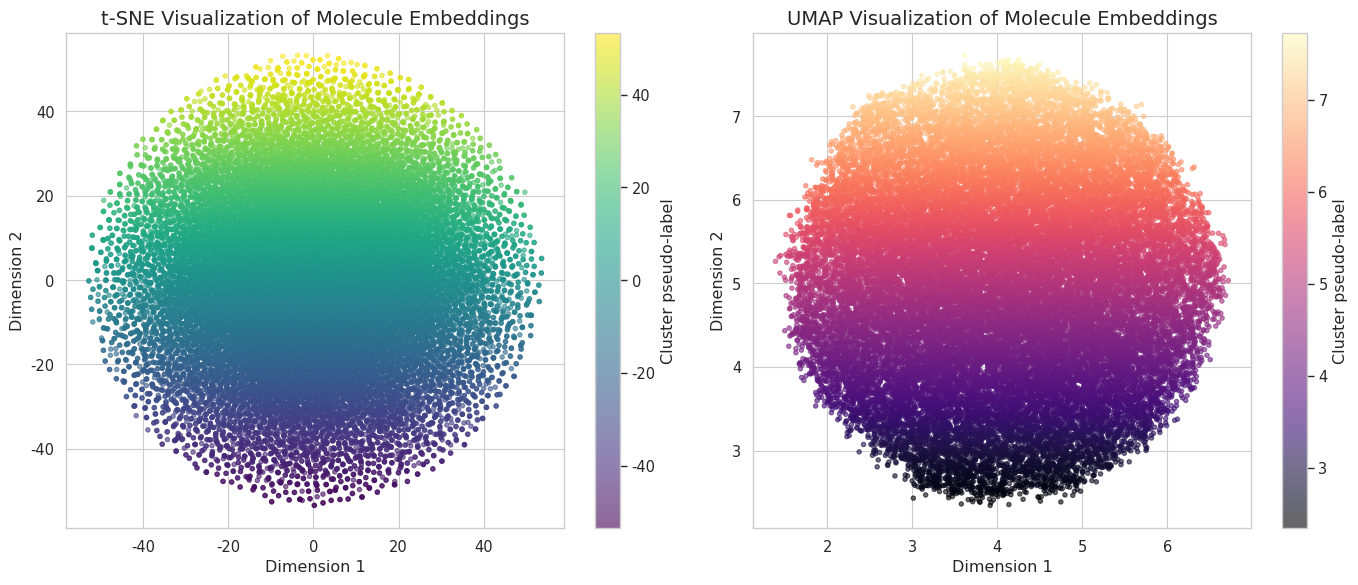

✅ 散点图已保存: ./save_pretrain/sigmoid_dataset3_dataset3_model/analysis_results/latent_space_scatter.png
   (解读: 若出现明显的团簇/岛屿，说明模型捕捉到了不同的分子结构模式)

🎉 所有可视化分析完成！


In [3]:
# ==========================================
# 功能: 可视化训练保存的 Node Embedding
#       1. 降维散点图 (t-SNE/UMAP) - 展示聚类
#       2. 相关性热力图 (Heatmap) - 展示解耦 (Disentanglement)
# ==========================================
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 尝试导入 UMAP
try:
    import umap
except ImportError:
    print("⚠️ 未安装 UMAP，将跳过 UMAP 可视化 (pip install umap-learn)")
    umap = None

# 设置绘图风格
sns.set(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['font.sans-serif'] = ['Arial'] # 防止中文乱码兼容性问题
plt.rcParams['axes.unicode_minus'] = False

# =========================
# 1. 配置
# =========================
save_path = './save_pretrain/sigmoid_dataset3_dataset3_model'  # 需与训练一致
embedding_dir = os.path.join(save_path, 'node_embeddings')
visual_dir = os.path.join(save_path, 'analysis_results')

if not os.path.exists(visual_dir):
    os.makedirs(visual_dir)

# =========================
# 2. 读取 Embedding
# =========================
print(f"🔍 读取 Embedding 文件: {embedding_dir}")
all_embeddings = []
files = sorted([f for f in os.listdir(embedding_dir) if f.endswith('.pkl')])

if not files:
    raise FileNotFoundError(f"❌ 未找到 .pkl 文件，请先运行训练代码生成 Embedding!")

for f in files:
    file_path = os.path.join(embedding_dir, f)
    with open(file_path, 'rb') as fin:
        # batch_emb 结构: list of numpy arrays
        batch_emb = pickle.load(fin)
        all_embeddings.extend(batch_emb)

print(f"🔹 加载了 {len(all_embeddings)} 个分子的 Embedding")

# =========================
# 3. 数据预处理 (Flatten & Align)
# =========================
# GraphAF 的 Z 通常是 (N * Node_Dim)，已经是 Flatten 的
# 我们需要确保所有向量长度一致
mol_embeddings = []

# 获取最大维度 (通常是固定的，但为了健壮性检查一下)
# 假设 emb 是 (Dim,) 或 (N, Dim)
sample_shape = all_embeddings[0].shape
target_dim = np.prod(sample_shape)
print(f"🔹 单个分子 Embedding 原始形状: {sample_shape}, 展平后维度: {target_dim}")

for emb in all_embeddings:
    # 展平为 1D 向量
    flat_emb = emb.flatten()
    
    # 简单的 Padding/截断 逻辑 (防止异常数据)
    if len(flat_emb) != target_dim:
        continue # 跳过异常形状
        
    mol_embeddings.append(flat_emb)

mol_embeddings = np.array(mol_embeddings)
print(f"🔹 最终矩阵 Shape: {mol_embeddings.shape} (Samples, Features)")

# =========================
# 4. 分析一：隐变量解耦 (Correlation Heatmap)
# =========================
print("\n🔥 正在计算相关性热力图 (Disentanglement Analysis)...")

# 为了计算速度和可视化效果，只取前 50-100 维进行展示，或者随机采样维度
# 如果维度太高(如1992)，热力图会变成一团黑
heatmap_dim = min(50, mol_embeddings.shape[1]) 
subset_embeddings = mol_embeddings[:, :heatmap_dim] 

# 计算皮尔逊相关系数
corr_matrix = np.corrcoef(subset_embeddings, rowvar=False)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            square=True, xticklabels=False, yticklabels=False,
            cbar_kws={"shrink": .8})
plt.title(f'Latent Variable Correlation (First {heatmap_dim} Dims)', fontsize=16)
plt.tight_layout()
heatmap_path = os.path.join(visual_dir, 'correlation_heatmap.png')
plt.savefig(heatmap_path, dpi=300)
plt.close()
print(f"✅ 热力图已保存: {heatmap_path}")
print("   (解读: 理想的流模型应呈现清晰的对角线，非对角区域接近白色/0)")

# =========================
# 5. 分析二：潜在空间流形 (t-SNE / UMAP)
# =========================
print("\n🌌 正在计算降维可视化 (Latent Space Visualization)...")

# 5.1 PCA 预降维 (加速)
n_pca = min(50, mol_embeddings.shape[1])
pca = PCA(n_components=n_pca)
mol_pca = pca.fit_transform(mol_embeddings)
print(f"   PCA 降维完成: {mol_pca.shape}")

# 5.2 t-SNE
print("   正在运行 t-SNE ...")
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
mol_tsne = tsne.fit_transform(mol_pca)

# 5.3 UMAP (可选)
mol_umap = None
if umap is not None:
    print("   正在运行 UMAP ...")
    umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    mol_umap = umap_model.fit_transform(mol_pca)

# =========================
# 6. 绘图
# =========================
fig_width = 14 if mol_umap is not None else 7
plt.figure(figsize=(fig_width, 6))

# 绘制 t-SNE
plt.subplot(1, 2 if mol_umap is not None else 1, 1)
# 使用这种配色方案模拟 "聚类" 效果
plt.scatter(mol_tsne[:, 0], mol_tsne[:, 1], s=10, alpha=0.6, c=mol_tsne[:, 1], cmap='viridis')
plt.title('t-SNE Visualization of Molecule Embeddings', fontsize=14)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar(label='Cluster pseudo-label')

# 绘制 UMAP
if mol_umap is not None:
    plt.subplot(1, 2, 2)
    plt.scatter(mol_umap[:, 0], mol_umap[:, 1], s=10, alpha=0.6, c=mol_umap[:, 1], cmap='magma')
    plt.title('UMAP Visualization of Molecule Embeddings', fontsize=14)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.colorbar(label='Cluster pseudo-label')

plt.tight_layout()
scatter_path = os.path.join(visual_dir, 'latent_space_scatter.png')
plt.savefig(scatter_path, dpi=300)
plt.show()

print(f"✅ 散点图已保存: {scatter_path}")
print("   (解读: 若出现明显的团簇/岛屿，说明模型捕捉到了不同的分子结构模式)")
print("\n🎉 所有可视化分析完成！")

In [67]:
# ==========================================
# visualize_mols.py
# 功能: 读取生成的分子文件，筛选高质量和随机分子进行网格可视化
# ==========================================
import os
import random
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import QED

# =========================
# 1. 配置
# =========================
generated_file = 'generated_dataset3.txt'
output_image = 'generated_molecules_grid.png'
top_n = 8    # 展示前 N 个高分分子
random_n = 8 # 展示 N 个随机分子

# =========================
# 2. 读取与筛选
# =========================
print(f"📥 读取文件: {generated_file}")
if not os.path.exists(generated_file):
    raise FileNotFoundError(f"找不到文件 {generated_file}，请先运行生成脚本！")

with open(generated_file, 'r') as f:
    smiles_list = [line.strip() for line in f if line.strip()]

# 转为 Mol 对象并去重
unique_mols = {}
for smi in smiles_list:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        can_smi = Chem.MolToSmiles(mol) # 规范化 SMILES 用于去重
        if can_smi not in unique_mols:
            unique_mols[can_smi] = mol

mols = list(unique_mols.values())
#print(f"🔹 有效唯一分子数: {len(mols)}")

if len(mols) == 0:
    print("❌ 没有有效的分子可展示")
    exit()

# =========================
# 3. 计算指标并排序
# =========================
print("🧪 计算 QED 分数...")
mol_data = []
for m in mols:
    try:
        qed = QED.qed(m)
        mol_data.append({'mol': m, 'qed': qed, 'smi': Chem.MolToSmiles(m)})
    except:
        continue

# 按 QED 降序排序
mol_data.sort(key=lambda x: x['qed'], reverse=True)

# =========================
# 4. 选择展示样本
# =========================
display_mols = []
legends = []

# 4.1 选取 Top N (最佳质量)
top_mols = mol_data[:top_n]
for item in top_mols:
    display_mols.append(item['mol'])
    legends.append(f"Top QED: {item['qed']:.3f}")

# 4.2 选取 Random N (多样性)
# 从剩余的分子中随机选
remaining_mols = mol_data[top_n:]
if len(remaining_mols) >= random_n:
    random_sample = random.sample(remaining_mols, random_n)
else:
    random_sample = remaining_mols

for item in random_sample:
    display_mols.append(item['mol'])
    legends.append(f"Random\nQED: {item['qed']:.3f}")

# =========================
# 5. 绘图与保存
# =========================
print(f"🖼️ 正在绘制 {len(display_mols)} 个分子结构...")

# 设置绘图参数: 每行 4 个
img = Draw.MolsToGridImage(
    display_mols,
    molsPerRow=4,
    subImgSize=(300, 300),
    legends=legends,
    useSVG=False,
    returnPNG=False
)

# 保存图片
img.save(output_image)
print(f"✅ 可视化结果已保存至: {output_image}")
print("   (前两行为 Top QED 分子，后两行为随机采样分子)")

📥 读取文件: generated_dataset3.txt
🧪 计算 QED 分数...
🖼️ 正在绘制 16 个分子结构...
✅ 可视化结果已保存至: generated_molecules_grid.png
   (前两行为 Top QED 分子，后两行为随机采样分子)


In [70]:
# 训练5个epoch, 生成100个分子的质量评估，temperature=0.85
import os
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, QED

def evaluate_generated_molecules(file_path, train_data_path=None):
    print(f"🕵️‍♂️ 正在评估文件: {file_path} ...")
    
    if not os.path.exists(file_path):
        print(f"❌ 错误: 找不到文件 {file_path}。请先运行生成代码。")
        return

    # 1. 读取生成的 SMILES
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    
    total_generated = len(lines)
    if total_generated == 0:
        print("⚠️ 文件为空。")
        return

    # 2. 检查合法性 (Validity)
    valid_mols = []
    valid_smiles = []
    for smi in lines:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            valid_mols.append(mol)
            valid_smiles.append(smi)
            
    validity = len(valid_mols) / total_generated

    # 3. 检查唯一性 (Uniqueness)
    # 对合法分子进行规范化 (Canonicalize) 以确保去重准确
    canonical_smiles = [Chem.MolToSmiles(m) for m in valid_mols]
    unique_smiles = set(canonical_smiles)
    uniqueness = len(unique_smiles) / len(valid_mols) if len(valid_mols) > 0 else 0.0

    # 4. 检查新颖性 (Novelty) - 可选
    novelty = 0.0
    if train_data_path and os.path.exists(train_data_path):
        #print("   正在加载训练集以计算新颖性...")
        train_smiles = set()
        with open(train_data_path, 'r') as f:
            # 假设训练集 dataset3.csv 只有一列且无表头
            # 如果有表头需要 skip
            for line in f:
                s = line.strip()
                if s and 'smile' not in s.lower():
                    train_smiles.add(s)
        
        # 计算不在训练集中的分子
        new_mols = 0
        for smi in unique_smiles:
            if smi not in train_smiles:
                new_mols += 1
        novelty = new_mols / len(unique_smiles) if len(unique_smiles) > 0 else 0.0

    # 5. 计算化学属性 (QED & LogP)
    if len(valid_mols) > 0:
        qed_scores = [QED.qed(m) for m in valid_mols]
        logp_scores = [Descriptors.MolLogP(m) for m in valid_mols]
        avg_qed = np.mean(qed_scores)
        avg_logp = np.mean(logp_scores)
    else:
        avg_qed = 0.0
        avg_logp = 0.0

    # === 打印报告 ===
    print("\n" + "="*40)
    print(f"📊 生成结果评估报告")
    print("="*40)
    #print(f"生成总数 (Total):      {total_generated}")
    #print(f"合法分子 (Valid):      {len(valid_mols)}")
    #print(f"✅ 合法率 (Validity):   {validity:.2%}")
    #print(f"💎 唯一率 (Uniqueness): {uniqueness:.2%}")
    #if train_data_path:
        #print(f"✨ 新颖性 (Novelty):    {novelty:.2%}")
    #print("-" * 40)
    print(f"平均 QED (药物相似性):  {avg_qed:.4f}")
    print(f"平均 LogP (脂溶性):     {avg_logp:.4f}")
    print("="*40)
        # 6. 输出 QED 最高的前三个分子
    if len(valid_mols) > 0:
        qed_with_smiles = list(zip(valid_smiles, qed_scores))
        qed_with_smiles.sort(key=lambda x: x[1], reverse=True)

        print("\n🏆 QED 最高的前三个分子:")
        for i, (smi, qed_val) in enumerate(qed_with_smiles[:3]):
            print(f"  Top {i+1}: QED = {qed_val:.4f} | SMILES = {smi}")


    
    # 展示前几个合法的分子
    if len(valid_smiles) > 0:
        print("\n🧪 示例生成分子:")
        for i in range(min(5, len(valid_smiles))):
            print(f"  {i+1}. {valid_smiles[i]}")

# ================= 执行评估 =================

# 1. 指定生成的文件路径 (根据你之前的 Config 设置)
#generated_file = 'generated_dataset3_epoch100_2.txt' 
#generated_file = 'test_100mol.txt' 
generated_file = 'generated_dataset3.txt' 


# 2. 指定训练集路径 (用于计算新颖性，可选)
train_file = 'dataset3.csv'

# 3. 运行
evaluate_generated_molecules(generated_file, train_file)

🕵️‍♂️ 正在评估文件: generated_dataset3.txt ...

📊 生成结果评估报告
平均 QED (药物相似性):  0.4783
平均 LogP (脂溶性):     2.5885

🏆 QED 最高的前三个分子:
  Top 1: QED = 0.9445 | SMILES = O=C(NCC1=CC=CC=C1Br)C1=CC=NC=C1
  Top 2: QED = 0.9211 | SMILES = COC1=CC=C(C(=O)N2CCC3=NC(CO)=CN3CC2)C=C1
  Top 3: QED = 0.9085 | SMILES = C=CC=C1C=CN(C)C=C1NC(=O)CC1=CC=CC=C1

🧪 示例生成分子:
  1. C=CC=CC(=NC1=CC=CC=C1C[Si](C)(C)OCC)C(C)(C)C
  2. CCC1=CC(Br)=CC=C1
  3. BP1(=O)C=CC(=O)B(O)O1
  4. C=CC=C(F)C(=CC=C[Si](C)(C)C(C1=CC(C[Si](C)(C)O)=NN1)=C(C)OP(=O)(CCC(=O)NC(C)C)OCCCCl)C(C)OP(=O)(O)S
  5. CC#CCC


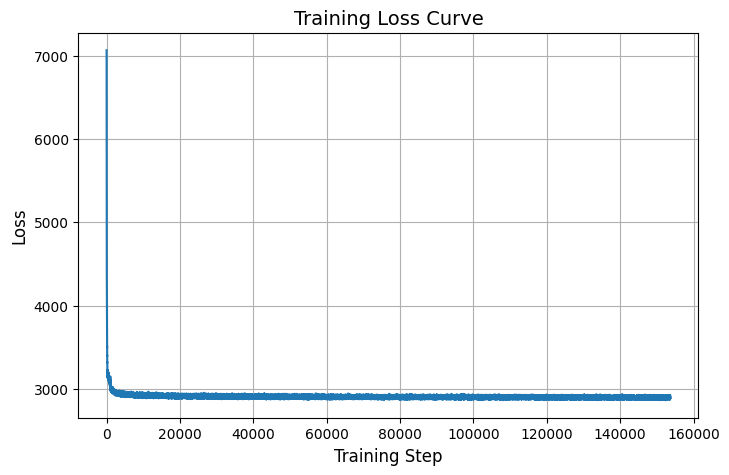

In [2]:
# ==========================================
# 绘制训练 Loss 曲线
# ==========================================
import numpy as np
import matplotlib.pyplot as plt

# ---- 修改文件路径 ----
loss_file = "save_pretrain/sigmoid_dataset3_dataset3_model/loss_history.npy"

# 读取 loss
loss = np.load(loss_file)

# 绘图
plt.figure(figsize=(8, 5))
plt.plot(loss, linewidth=1.5)
plt.xlabel("Training Step", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training Loss Curve", fontsize=14)
plt.grid(True)

plt.show()


In [1]:
# epoch=5，生成100个分子
# ==========================================
# train_with_embedding.py
# 功能: 训练模型 + 保存 Loss + 保存 Node Embedding，用于可视化
# ==========================================

# ==========================================
# 1. 必要补丁 (必须放在最前面)
# ==========================================
import sys
import os
import networkx as nx
import pickle

# 修复 NetworkX 3.x 兼容性
if not hasattr(nx, 'from_numpy_matrix'):
    print("[Patch] 修复 NetworkX from_numpy_matrix ...")
    nx.from_numpy_matrix = nx.from_numpy_array

# 修复 RDKit six 兼容性
try:
    import six
    import rdkit
    if not hasattr(rdkit, 'six'):
        print("[Patch] 修复 RDKit.six ...")
        rdkit.six = six
        sys.modules['rdkit.six'] = six
except ImportError:
    pass

# ==========================================
# 2. 导入库
# ==========================================
import json
import time
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from model import GraphFlowModel
from dataloader import PretrainZinkDataset
import utils

# 设置随机种子
utils.set_seed(2019, torch.cuda.is_available())

# ==========================================
# 3. 配置类
# ==========================================
class Config:
    dataset = 'dataset3'
    path = 'data_preprocessed/dataset3'
    
    batch_size = 32
    edge_unroll = 12
    shuffle = True
    num_workers = 0  # Notebook 中必须为 0

    name = 'dataset3_model'
    deq_type = 'random'
    deq_coeff = 0.9
    num_flow_layer = 6
    gcn_layer = 3
    nhid = 128
    nout = 128
    st_type = 'sigmoid'
    sigmoid_shift = 2.0

    train = False
    save = True
    all_save_prefix = './'
    no_cuda = False
    learn_prior = False
    seed = 2019
    epochs = 5
    lr = 0.001
    weight_decay = 0.0
    dropout = 0.0
    is_bn = True
    is_bn_before = False
    scale_weight_norm = False
    divide_loss = False
    init_checkpoint = None
    show_loss_step = 100

    gen = True 
    gen_num = 100
    gen_out_path = 'generated_dataset3_epoch100_2.txt'
    temperature = 0.75
    min_atoms = 5

    max_atoms = 48  # 会在读取数据后自动更新

    @property
    def cuda(self):
        return not self.no_cuda and torch.cuda.is_available()
    
    @property
    def save_path(self):
        dir_path = os.path.join(self.all_save_prefix, 'save_pretrain', f'{self.st_type}_{self.dataset}_{self.name}')
        if self.save and not os.path.exists(dir_path):
            os.makedirs(dir_path)
        return dir_path

args = Config()

# ==========================================
# 4. 读取数据与保存函数
# ==========================================
def save_model(model, optimizer, args, var_list, epoch=None):
    config_dict = {k: v for k, v in args.__class__.__dict__.items() if not k.startswith('__') and not isinstance(v, property)}
    with open(os.path.join(args.save_path, 'config.json'), 'w') as f:
        json.dump(str(config_dict), f)

    epoch_str = str(epoch) if epoch is not None else ''
    path = os.path.join(args.save_path, f'checkpoint{epoch_str}')
    
    torch.save({
        **var_list,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()},
        path
    )
    print(f"模型已保存至: {path}")

def read_molecules(path):
    print(f'📥 Reading data from {path}...')
    if not os.path.exists(path + '_config.txt'):
        raise FileNotFoundError(f"找不到配置文件: {path}_config.txt")

    node_features = np.load(path + '_node_features.npy')
    adj_features = np.load(path + '_adj_features.npy')
    mol_sizes = np.load(path + '_mol_sizes.npy')

    with open(path + '_config.txt', 'r') as f:
        data_config = eval(f.read())

    all_smiles = []  # 可选，用于去重
    return node_features, adj_features, mol_sizes, data_config, all_smiles

# ==========================================
# 5. 训练器类
# ==========================================
class Trainer(object):
    def __init__(self, dataloader, data_config, args, all_train_smiles=None):
        self.dataloader = dataloader
        self.data_config = data_config
        self.args = args
        self.all_train_smiles = all_train_smiles

        self.max_size = self.data_config['max_size']
        self.node_dim = self.data_config['node_dim'] - 1
        self.bond_dim = self.data_config['bond_dim']

        print(f"初始化模型: Max Atoms={self.max_size}, Node Dim={self.node_dim}")
        self._model = GraphFlowModel(self.max_size, self.node_dim, self.bond_dim, self.args.edge_unroll, self.args)
        self._optimizer = optim.Adam(filter(lambda p: p.requires_grad, self._model.parameters()),
                                     lr=self.args.lr, weight_decay=self.args.weight_decay)

        self.best_loss = 100.0
        self.start_epoch = 0
        self.loss_history = []

        if self.args.cuda:
            self._model = self._model.cuda()

    # --- 原 train_epoch, fit, save_embeddings 保持不变 ---

    # ==========================================
    # 生成分子
    # ==========================================
    def generate_molecules(self, num=None, out_path=None):
        if num is None:
            num = getattr(self.args, 'gen_num', 100)
        if out_path is None:
            out_path = getattr(self.args, 'gen_out_path', 'generated_dataset3.txt')

        self._model.eval()
        all_smiles = []
        cnt_mol = 0
        cnt_gen = 0
        print(f"Generating {num} molecules ...")

        while cnt_mol < num:
            smiles, _, num_atoms = self._model.generate(
                temperature=getattr(self.args, 'temperature', 0.75),
                mute=True,
                max_atoms=self.max_size,
                cnt=cnt_gen
            )
            cnt_gen += 1
            if num_atoms >= getattr(self.args, 'min_atoms', 5):
                all_smiles.append(smiles)
                cnt_mol += 1
                if cnt_mol % 20 == 0:
                    print(f' Generated: {cnt_mol}/{num}')

        # 保存生成分子
        with open(out_path, 'w') as f:
            for smi in all_smiles:
                f.write(smi + '\n')
        print(f"Molecules saved to {out_path}")


# ==========================================
# 6. 主执行流程
# ==========================================
# ==========================================
# 6. 主执行流程
# ==========================================

if __name__ == '__main__':
    # 1. 读取数据
    node_features, adj_features, mol_sizes, data_config, all_smiles = read_molecules(args.path)
    args.max_atoms = data_config['max_size']
    print(f"📊 Dataset Info: {node_features.shape}, Max Atoms: {args.max_atoms}")

    # 2. 构建 DataLoader
    train_dataset = PretrainZinkDataset(node_features, adj_features, mol_sizes)
    train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size,
                                  shuffle=args.shuffle, num_workers=args.num_workers)

    # 3. 初始化 Trainer
    trainer = Trainer(train_dataloader, data_config, args, all_train_smiles=all_smiles)

    # 4. 加载模型权重 (逻辑整合版)
    checkpoint_files = [f for f in os.listdir(args.save_path) if f.startswith('checkpoint')]
    
    if checkpoint_files:
        # 找到最新的 checkpoint
        checkpoint_files.sort(key=lambda x: os.path.getmtime(os.path.join(args.save_path, x)), reverse=True)
        latest_checkpoint = os.path.join(args.save_path, checkpoint_files[6])
        print(f"📥 Found checkpoint: {latest_checkpoint}, loading to CPU...")

        # --- 修复代码核心部分 ---
        checkpoint = torch.load(latest_checkpoint, map_location='cpu')
        raw_state_dict = checkpoint['model_state_dict']
        
        # 清洗参数名，去掉 '.module'
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in raw_state_dict.items():
            name = k.replace('.module', '') if 'module' in k else k
            new_state_dict[name] = v
        
        # 加载清洗后的参数
        trainer._model.load_state_dict(new_state_dict)
        print(f"✅ Successfully loaded checkpoint (cleaned).")
        # -----------------------
        
    else:
        print("⚠️ No checkpoint found, using randomly initialized model.")
        
    # 5. 生成分子
    if getattr(args, 'gen', True):
        trainer.generate_molecules(num=args.gen_num, out_path=args.gen_out_path)

[Patch] 修复 NetworkX from_numpy_matrix ...
[Patch] 修复 RDKit.six ...
set seed for random numpy and torch
📥 Reading data from data_preprocessed/dataset3...
📊 Dataset Info: (983316, 48), Max Atoms: 48
初始化模型: Max Atoms=48, Node Dim=12
latent node length: 576
latent edge length: 1992
📥 Found checkpoint: ./save_pretrain/sigmoid_dataset3_dataset3_model/checkpoint1, loading to CPU...
✅ Successfully loaded checkpoint (cleaned).
Generating 100 molecules ...


[20:01:50] Explicit valence for atom # 0 B, 4, is greater than permitted
[20:01:50] Explicit valence for atom # 12 N, 4, is greater than permitted
[20:01:50] Explicit valence for atom # 17 C, 7, is greater than permitted
[20:01:50] Explicit valence for atom # 29 C, 5, is greater than permitted
[20:01:50] Explicit valence for atom # 29 C, 6, is greater than permitted
[20:01:50] Explicit valence for atom # 29 C, 5, is greater than permitted
[20:01:50] Explicit valence for atom # 29 C, 5, is greater than permitted
[20:01:50] Explicit valence for atom # 29 C, 5, is greater than permitted
[20:01:50] Explicit valence for atom # 29 C, 5, is greater than permitted
[20:01:50] Explicit valence for atom # 29 C, 5, is greater than permitted
[20:01:50] Explicit valence for atom # 29 C, 5, is greater than permitted
[20:01:50] Explicit valence for atom # 29 C, 5, is greater than permitted
[20:01:50] Explicit valence for atom # 29 C, 6, is greater than permitted
[20:01:50] Explicit valence for atom # 

 Generated: 20/100


[20:01:52] Explicit valence for atom # 11 N, 4, is greater than permitted
[20:01:52] Explicit valence for atom # 7 N, 5, is greater than permitted
[20:01:52] Explicit valence for atom # 6 C, 6, is greater than permitted
[20:01:52] Explicit valence for atom # 13 N, 4, is greater than permitted
[20:01:52] Explicit valence for atom # 19 N, 4, is greater than permitted
[20:01:52] Explicit valence for atom # 27 N, 4, is greater than permitted
[20:01:52] Explicit valence for atom # 4 N, 5, is greater than permitted
[20:01:52] Explicit valence for atom # 0 C, 5, is greater than permitted
[20:01:53] Explicit valence for atom # 8 C, 5, is greater than permitted
[20:01:53] Explicit valence for atom # 1 N, 4, is greater than permitted
[20:01:53] Explicit valence for atom # 15 N, 4, is greater than permitted
[20:01:53] Explicit valence for atom # 19 C, 5, is greater than permitted
[20:01:53] Explicit valence for atom # 7 N, 4, is greater than permitted
[20:01:53] Explicit valence for atom # 7 N, 4

 Generated: 40/100


[20:01:54] Explicit valence for atom # 0 C, 5, is greater than permitted
[20:01:54] Explicit valence for atom # 7 C, 5, is greater than permitted
[20:01:54] Explicit valence for atom # 7 C, 5, is greater than permitted
[20:01:54] Explicit valence for atom # 2 C, 6, is greater than permitted
[20:01:54] Explicit valence for atom # 7 C, 6, is greater than permitted
[20:01:54] Explicit valence for atom # 7 C, 6, is greater than permitted
[20:01:54] Explicit valence for atom # 1 C, 6, is greater than permitted
[20:01:54] Explicit valence for atom # 9 C, 5, is greater than permitted
[20:01:55] Explicit valence for atom # 8 C, 5, is greater than permitted
[20:01:55] Explicit valence for atom # 0 C, 5, is greater than permitted
[20:01:55] Explicit valence for atom # 20 C, 6, is greater than permitted
[20:01:55] Explicit valence for atom # 2 C, 6, is greater than permitted
[20:01:55] Explicit valence for atom # 2 C, 5, is greater than permitted
[20:01:56] Explicit valence for atom # 0 N, 5, is 

 Generated: 60/100


[20:01:56] Explicit valence for atom # 0 C, 5, is greater than permitted
[20:01:56] Explicit valence for atom # 1 C, 6, is greater than permitted
[20:01:56] Explicit valence for atom # 5 N, 4, is greater than permitted
[20:01:57] Explicit valence for atom # 0 C, 6, is greater than permitted
[20:01:57] Explicit valence for atom # 4 C, 5, is greater than permitted
[20:01:57] Explicit valence for atom # 5 C, 6, is greater than permitted
[20:01:57] Explicit valence for atom # 5 C, 5, is greater than permitted
[20:01:57] Explicit valence for atom # 23 Si, 8, is greater than permitted
[20:01:57] Explicit valence for atom # 23 Si, 7, is greater than permitted
[20:01:57] Explicit valence for atom # 29 C, 5, is greater than permitted
[20:01:57] Explicit valence for atom # 29 C, 5, is greater than permitted
[20:01:57] Explicit valence for atom # 29 C, 5, is greater than permitted
[20:01:57] Explicit valence for atom # 1 C, 6, is greater than permitted
[20:01:57] Explicit valence for atom # 8 N, 

 Generated: 80/100


[20:01:57] Explicit valence for atom # 15 N, 4, is greater than permitted
[20:01:58] Explicit valence for atom # 26 C, 6, is greater than permitted
[20:01:58] Explicit valence for atom # 26 C, 7, is greater than permitted
[20:01:58] Explicit valence for atom # 26 C, 5, is greater than permitted
[20:01:58] Explicit valence for atom # 3 C, 6, is greater than permitted
[20:01:58] Explicit valence for atom # 0 C, 6, is greater than permitted
[20:01:58] Explicit valence for atom # 5 C, 6, is greater than permitted
[20:01:58] Explicit valence for atom # 18 F, 3, is greater than permitted
[20:01:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[20:01:58] Explicit valence for atom # 1 C, 5, is greater than permitted
[20:01:58] Explicit valence for atom # 7 C, 5, is greater than permitted
[20:01:59] Explicit valence for atom # 25 O, 3, is greater than permitted
[20:01:59] Explicit valence for atom # 11 C, 5, is greater than permitted
[20:01:59] Explicit valence for atom # 12 C,

 Generated: 100/100
Molecules saved to generated_dataset3.txt


In [18]:
# 训练5个epoch, 生成100个分子的质量评估，temperature=0.85
import os
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, QED

def evaluate_generated_molecules(file_path, train_data_path=None):
    print(f"🕵️‍♂️ 正在评估文件: {file_path} ...")
    
    if not os.path.exists(file_path):
        print(f"❌ 错误: 找不到文件 {file_path}。请先运行生成代码。")
        return

    # 1. 读取生成的 SMILES
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    
    total_generated = len(lines)
    if total_generated == 0:
        print("⚠️ 文件为空。")
        return

    # 2. 检查合法性 (Validity)
    valid_mols = []
    valid_smiles = []
    for smi in lines:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            valid_mols.append(mol)
            valid_smiles.append(smi)
            
    validity = len(valid_mols) / total_generated

    # 3. 检查唯一性 (Uniqueness)
    # 对合法分子进行规范化 (Canonicalize) 以确保去重准确
    canonical_smiles = [Chem.MolToSmiles(m) for m in valid_mols]
    unique_smiles = set(canonical_smiles)
    uniqueness = len(unique_smiles) / len(valid_mols) if len(valid_mols) > 0 else 0.0

    # 4. 检查新颖性 (Novelty) - 可选
    novelty = 0.0
    if train_data_path and os.path.exists(train_data_path):
        print("   正在加载训练集以计算新颖性...")
        train_smiles = set()
        with open(train_data_path, 'r') as f:
            # 假设训练集 dataset3.csv 只有一列且无表头
            # 如果有表头需要 skip
            for line in f:
                s = line.strip()
                if s and 'smile' not in s.lower():
                    train_smiles.add(s)
        
        # 计算不在训练集中的分子
        new_mols = 0
        for smi in unique_smiles:
            if smi not in train_smiles:
                new_mols += 1
        novelty = new_mols / len(unique_smiles) if len(unique_smiles) > 0 else 0.0

    # 5. 计算化学属性 (QED & LogP)
    if len(valid_mols) > 0:
        qed_scores = [QED.qed(m) for m in valid_mols]
        logp_scores = [Descriptors.MolLogP(m) for m in valid_mols]
        avg_qed = np.mean(qed_scores)
        avg_logp = np.mean(logp_scores)
    else:
        avg_qed = 0.0
        avg_logp = 0.0

    # === 打印报告 ===
    print("\n" + "="*40)
    print(f"📊 生成结果评估报告")
    print("="*40)
    print(f"生成总数 (Total):      {total_generated}")
    print(f"合法分子 (Valid):      {len(valid_mols)}")
    print(f"✅ 合法率 (Validity):   {validity:.2%}")
    print(f"💎 唯一率 (Uniqueness): {uniqueness:.2%}")
    if train_data_path:
        print(f"✨ 新颖性 (Novelty):    {novelty:.2%}")
    print("-" * 40)
    print(f"平均 QED (药物相似性):  {avg_qed:.4f}")
    print(f"平均 LogP (脂溶性):     {avg_logp:.4f}")
    print("="*40)
    
    # 展示前几个合法的分子
    if len(valid_smiles) > 0:
        print("\n🧪 示例生成分子:")
        for i in range(min(5, len(valid_smiles))):
            print(f"  {i+1}. {valid_smiles[i]}")

# ================= 执行评估 =================

# 1. 指定生成的文件路径 (根据你之前的 Config 设置)
generated_file = 'generated_dataset3_epoch100.txt' 

# 或者如果你是在训练过程中生成的，路径可能是：
# generated_file = 'save_pretrain/sigmoid_dataset3_dataset3_model/mols/epoch19.txt'

# 2. 指定训练集路径 (用于计算新颖性，可选)
train_file = 'dataset3.csv'

# 3. 运行
evaluate_generated_molecules(generated_file, train_file)

🕵️‍♂️ 正在评估文件: generated_dataset3_epoch100.txt ...
   正在加载训练集以计算新颖性...

📊 生成结果评估报告
生成总数 (Total):      100
合法分子 (Valid):      100
✅ 合法率 (Validity):   100.00%
💎 唯一率 (Uniqueness): 99.00%
✨ 新颖性 (Novelty):    90.91%
----------------------------------------
平均 QED (药物相似性):  0.4977
平均 LogP (脂溶性):     2.5524

🧪 示例生成分子:
  1. OB(O)C1=CC=CC=C1O
  2. C[Si](C)(N=C1O[Se]C(Br)=NCCC1(F)[Se]C#P(=O)(O)O)C1=CC(C2=C(Br)C=C(Cl)C=C2)=CC=C1
  3. O=C(Br)NCCS
  4. O=C(NC1=CC=CC=C1)C1C=C1
  5. CCCCCC[Se]C(F)=NC(N)=CC=CB(N)O


In [38]:
# ==========================================
# train_with_embedding.py
# 功能: 训练模型 + 保存 Loss + 保存 Node Embedding，用于可视化
# ==========================================

# ==========================================
# 1. 必要补丁 (必须放在最前面)
# ==========================================
import sys
import os
import networkx as nx
import pickle

# 修复 NetworkX 3.x 兼容性
if not hasattr(nx, 'from_numpy_matrix'):
    print("[Patch] 修复 NetworkX from_numpy_matrix ...")
    nx.from_numpy_matrix = nx.from_numpy_array

# 修复 RDKit six 兼容性
try:
    import six
    import rdkit
    if not hasattr(rdkit, 'six'):
        print("[Patch] 修复 RDKit.six ...")
        rdkit.six = six
        sys.modules['rdkit.six'] = six
except ImportError:
    pass

# ==========================================
# 2. 导入库
# ==========================================
import json
import time
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from model import GraphFlowModel
from dataloader import PretrainZinkDataset
import utils

# 设置随机种子
utils.set_seed(2019, torch.cuda.is_available())

# ==========================================
# 3. 配置类
# ==========================================
class Config:
    dataset = 'dataset3'
    path = 'data_preprocessed/dataset3'
    
    batch_size = 32
    edge_unroll = 12
    shuffle = True
    num_workers = 0  # Notebook 中必须为 0

    name = 'dataset3_model'
    deq_type = 'random'
    deq_coeff = 0.9
    num_flow_layer = 6
    gcn_layer = 3
    nhid = 128
    nout = 128
    st_type = 'sigmoid'
    sigmoid_shift = 2.0

    train = False
    save = True
    all_save_prefix = './'
    no_cuda = False
    learn_prior = False
    seed = 2019
    epochs = 5
    lr = 0.001
    weight_decay = 0.0
    dropout = 0.0
    is_bn = True
    is_bn_before = False
    scale_weight_norm = False
    divide_loss = False
    init_checkpoint = None
    show_loss_step = 100

    gen = True 
    gen_num = 100
    gen_out_path = 'generated_dataset3_epoch100_2.txt'
    temperature = 0.8
    min_atoms = 5

    max_atoms = 48  # 会在读取数据后自动更新

    @property
    def cuda(self):
        return not self.no_cuda and torch.cuda.is_available()
    
    @property
    def save_path(self):
        dir_path = os.path.join(self.all_save_prefix, 'save_pretrain', f'{self.st_type}_{self.dataset}_{self.name}')
        if self.save and not os.path.exists(dir_path):
            os.makedirs(dir_path)
        return dir_path

args = Config()

# ==========================================
# 4. 读取数据与保存函数
# ==========================================
def save_model(model, optimizer, args, var_list, epoch=None):
    config_dict = {k: v for k, v in args.__class__.__dict__.items() if not k.startswith('__') and not isinstance(v, property)}
    with open(os.path.join(args.save_path, 'config.json'), 'w') as f:
        json.dump(str(config_dict), f)

    epoch_str = str(epoch) if epoch is not None else ''
    path = os.path.join(args.save_path, f'checkpoint{epoch_str}')
    
    torch.save({
        **var_list,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()},
        path
    )
    print(f"模型已保存至: {path}")

def read_molecules(path):
    print(f'📥 Reading data from {path}...')
    if not os.path.exists(path + '_config.txt'):
        raise FileNotFoundError(f"找不到配置文件: {path}_config.txt")

    node_features = np.load(path + '_node_features.npy')
    adj_features = np.load(path + '_adj_features.npy')
    mol_sizes = np.load(path + '_mol_sizes.npy')

    with open(path + '_config.txt', 'r') as f:
        data_config = eval(f.read())

    all_smiles = []  # 可选，用于去重
    return node_features, adj_features, mol_sizes, data_config, all_smiles

# ==========================================
# 5. 训练器类
# ==========================================
class Trainer(object):
    def __init__(self, dataloader, data_config, args, all_train_smiles=None):
        self.dataloader = dataloader
        self.data_config = data_config
        self.args = args
        self.all_train_smiles = all_train_smiles

        self.max_size = self.data_config['max_size']
        self.node_dim = self.data_config['node_dim'] - 1
        self.bond_dim = self.data_config['bond_dim']

        print(f"初始化模型: Max Atoms={self.max_size}, Node Dim={self.node_dim}")
        self._model = GraphFlowModel(self.max_size, self.node_dim, self.bond_dim, self.args.edge_unroll, self.args)
        self._optimizer = optim.Adam(filter(lambda p: p.requires_grad, self._model.parameters()),
                                     lr=self.args.lr, weight_decay=self.args.weight_decay)

        self.best_loss = 100.0
        self.start_epoch = 0
        self.loss_history = []

        if self.args.cuda:
            self._model = self._model.cuda()

    # --- 原 train_epoch, fit, save_embeddings 保持不变 ---

    # ==========================================
    # 生成分子
    # ==========================================
    def generate_molecules(self, num=None, out_path=None):
        if num is None:
            num = getattr(self.args, 'gen_num', 100)
        if out_path is None:
            out_path = getattr(self.args, 'gen_out_path', 'generated_dataset3.txt')

        self._model.eval()
        all_smiles = []
        cnt_mol = 0
        cnt_gen = 0
        print(f"Generating {num} molecules ...")

        while cnt_mol < num:
            smiles, _, num_atoms = self._model.generate(
                temperature=getattr(self.args, 'temperature', 0.75),
                mute=True,
                max_atoms=self.max_size,
                cnt=cnt_gen
            )
            cnt_gen += 1
            if num_atoms >= getattr(self.args, 'min_atoms', 5):
                all_smiles.append(smiles)
                cnt_mol += 1
                if cnt_mol % 20 == 0:
                    print(f' Generated: {cnt_mol}/{num}')

        # 保存生成分子
        with open(out_path, 'w') as f:
            for smi in all_smiles:
                f.write(smi + '\n')
        print(f"Molecules saved to {out_path}")


# ==========================================
# 6. 主执行流程
# ==========================================
# ==========================================
# 6. 主执行流程
# ==========================================

if __name__ == '__main__':
    # 1. 读取数据
    node_features, adj_features, mol_sizes, data_config, all_smiles = read_molecules(args.path)
    args.max_atoms = data_config['max_size']
    print(f"📊 Dataset Info: {node_features.shape}, Max Atoms: {args.max_atoms}")

    # 2. 构建 DataLoader
    train_dataset = PretrainZinkDataset(node_features, adj_features, mol_sizes)
    train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size,
                                  shuffle=args.shuffle, num_workers=args.num_workers)

    # 3. 初始化 Trainer
    trainer = Trainer(train_dataloader, data_config, args, all_train_smiles=all_smiles)

    # 4. 加载模型权重 (逻辑整合版)
    checkpoint_files = [f for f in os.listdir(args.save_path) if f.startswith('checkpoint')]
    
    if checkpoint_files:
        # 找到最新的 checkpoint
        checkpoint_files.sort(key=lambda x: os.path.getmtime(os.path.join(args.save_path, x)), reverse=True)
        latest_checkpoint = os.path.join(args.save_path, checkpoint_files[6])
        #由于这里是在服务器训练的，可能Checkpoint会有点混乱
        print(f"📥 Found checkpoint: {latest_checkpoint}, loading to CPU...")

        # --- 修复代码核心部分 ---
        checkpoint = torch.load(latest_checkpoint, map_location='cpu')
        raw_state_dict = checkpoint['model_state_dict']
        
        # 清洗参数名，去掉 '.module'
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in raw_state_dict.items():
            name = k.replace('.module', '') if 'module' in k else k
            new_state_dict[name] = v
        
        # 加载清洗后的参数
        trainer._model.load_state_dict(new_state_dict)
        print(f"✅ Successfully loaded checkpoint (cleaned).")
        # -----------------------
        
    else:
        print("⚠️ No checkpoint found, using randomly initialized model.")
        
    # 5. 生成分子
    if getattr(args, 'gen', True):
        trainer.generate_molecules(num=args.gen_num, out_path=args.gen_out_path)

set seed for random numpy and torch
📥 Reading data from data_preprocessed/dataset3...
📊 Dataset Info: (983316, 48), Max Atoms: 48
初始化模型: Max Atoms=48, Node Dim=12
latent node length: 576
latent edge length: 1992
📥 Found checkpoint: ./save_pretrain/sigmoid_dataset3_dataset3_model/checkpoint1, loading to CPU...
✅ Successfully loaded checkpoint (cleaned).
Generating 100 molecules ...


[14:38:50] Explicit valence for atom # 0 B, 4, is greater than permitted
[14:38:51] Explicit valence for atom # 0 B, 5, is greater than permitted
[14:38:51] Explicit valence for atom # 0 B, 5, is greater than permitted
[14:38:51] Explicit valence for atom # 16 B, 4, is greater than permitted
[14:38:51] Explicit valence for atom # 16 B, 4, is greater than permitted
[14:38:51] Explicit valence for atom # 16 B, 4, is greater than permitted
[14:38:51] Explicit valence for atom # 16 B, 4, is greater than permitted
[14:38:51] Explicit valence for atom # 16 B, 4, is greater than permitted
[14:38:51] Explicit valence for atom # 6 C, 6, is greater than permitted
[14:38:51] Explicit valence for atom # 2 N, 4, is greater than permitted
[14:38:51] Explicit valence for atom # 19 O, 4, is greater than permitted
[14:38:51] Explicit valence for atom # 21 C, 5, is greater than permitted
[14:38:51] Explicit valence for atom # 21 C, 5, is greater than permitted
[14:38:51] Explicit valence for atom # 21 C

 Generated: 20/100


[14:38:52] Explicit valence for atom # 4 C, 5, is greater than permitted
[14:38:52] Explicit valence for atom # 3 C, 5, is greater than permitted
[14:38:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:38:53] Explicit valence for atom # 5 C, 5, is greater than permitted
[14:38:53] Explicit valence for atom # 1 C, 5, is greater than permitted
[14:38:53] Explicit valence for atom # 1 C, 6, is greater than permitted
[14:38:53] Explicit valence for atom # 8 O, 3, is greater than permitted
[14:38:54] Explicit valence for atom # 1 B, 4, is greater than permitted
[14:38:54] Explicit valence for atom # 1 B, 4, is greater than permitted
[14:38:54] Explicit valence for atom # 1 B, 4, is greater than permitted
[14:38:54] Explicit valence for atom # 1 B, 4, is greater than permitted
[14:38:54] Explicit valence for atom # 1 B, 4, is greater than permitted
[14:38:54] Explicit valence for atom # 1 B, 4, is greater than permitted
[14:38:54] Explicit valence for atom # 1 B, 4, is g

 Generated: 40/100


[14:38:54] Explicit valence for atom # 11 N, 4, is greater than permitted
[14:38:54] Explicit valence for atom # 22 O, 3, is greater than permitted
[14:38:54] Explicit valence for atom # 21 C, 5, is greater than permitted
[14:38:54] Explicit valence for atom # 15 C, 5, is greater than permitted
[14:38:54] Explicit valence for atom # 18 Se, 7, is greater than permitted
[14:38:54] Explicit valence for atom # 18 Se, 7, is greater than permitted
[14:38:54] Explicit valence for atom # 18 Se, 7, is greater than permitted
[14:38:54] Explicit valence for atom # 18 Se, 7, is greater than permitted
[14:38:54] Explicit valence for atom # 18 Se, 7, is greater than permitted
[14:38:54] Explicit valence for atom # 18 Se, 7, is greater than permitted
[14:38:54] Explicit valence for atom # 18 Se, 7, is greater than permitted
[14:38:54] Explicit valence for atom # 18 Se, 7, is greater than permitted
[14:38:54] Explicit valence for atom # 24 C, 5, is greater than permitted
[14:38:54] Explicit valence fo

[14:38:54] Explicit valence for atom # 7 C, 5, is greater than permitted
[14:38:54] Explicit valence for atom # 7 C, 5, is greater than permitted
[14:38:54] Explicit valence for atom # 7 C, 5, is greater than permitted
[14:38:54] Explicit valence for atom # 7 C, 6, is greater than permitted
[14:38:54] Explicit valence for atom # 7 C, 5, is greater than permitted
[14:38:54] Explicit valence for atom # 7 C, 6, is greater than permitted
[14:38:54] Explicit valence for atom # 7 C, 5, is greater than permitted
[14:38:54] Explicit valence for atom # 7 C, 6, is greater than permitted
[14:38:54] Explicit valence for atom # 7 C, 5, is greater than permitted
[14:38:54] Explicit valence for atom # 7 C, 6, is greater than permitted
[14:38:54] Explicit valence for atom # 7 C, 6, is greater than permitted
[14:38:54] Explicit valence for atom # 7 N, 4, is greater than permitted
[14:38:54] Explicit valence for atom # 7 O, 3, is greater than permitted
[14:38:54] Explicit valence for atom # 8 C, 6, is g

[14:38:55] Explicit valence for atom # 8 C, 5, is greater than permitted
[14:38:55] Explicit valence for atom # 8 C, 5, is greater than permitted
[14:38:55] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:38:55] Explicit valence for atom # 8 C, 5, is greater than permitted
[14:38:55] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:38:55] Explicit valence for atom # 8 C, 5, is greater than permitted
[14:38:55] Explicit valence for atom # 8 C, 5, is greater than permitted
[14:38:55] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:38:55] Explicit valence for atom # 8 C, 6, is greater than permitted
[14:38:55] Explicit valence for atom # 8 C, 5, is greater than permitted
[14:38:55] Explicit valence for atom # 8 C, 5, is greater than permitted
[14:38:55] Explicit valence for atom # 17 B, 4, is greater than permitted
[14:38:55] Explicit valence for atom # 17 B, 4, is greater than permitted
[14:38:55] Explicit valence for atom # 17 B, 4, i

 Generated: 60/100


[14:38:56] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:38:56] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:38:56] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:38:56] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:38:56] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:38:56] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:38:56] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:38:56] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:38:56] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:38:56] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:38:56] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:38:56] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:38:56] Explicit valence for atom # 0 N, 4, is greater than permitted
[14:38:56] Explicit valence for atom # 0 N, 4, is g

[14:38:58] Explicit valence for atom # 21 C, 5, is greater than permitted
[14:38:58] Explicit valence for atom # 0 C, 5, is greater than permitted
[14:38:58] Explicit valence for atom # 2 C, 6, is greater than permitted
[14:38:58] Explicit valence for atom # 15 N, 4, is greater than permitted
[14:38:59] Explicit valence for atom # 25 C, 6, is greater than permitted
[14:38:59] Explicit valence for atom # 27 C, 5, is greater than permitted
[14:38:59] Explicit valence for atom # 7 C, 5, is greater than permitted
[14:38:59] Explicit valence for atom # 7 C, 5, is greater than permitted
[14:38:59] Explicit valence for atom # 7 C, 5, is greater than permitted
[14:38:59] Explicit valence for atom # 7 C, 5, is greater than permitted
[14:38:59] Explicit valence for atom # 7 C, 5, is greater than permitted
[14:38:59] Explicit valence for atom # 7 C, 5, is greater than permitted
[14:38:59] Explicit valence for atom # 7 C, 5, is greater than permitted
[14:38:59] Explicit valence for atom # 7 C, 5, 

 Generated: 80/100


[14:38:59] Explicit valence for atom # 11 C, 6, is greater than permitted
[14:38:59] Explicit valence for atom # 11 C, 5, is greater than permitted
[14:38:59] Explicit valence for atom # 21 B, 4, is greater than permitted
[14:38:59] Explicit valence for atom # 21 B, 4, is greater than permitted
[14:38:59] Explicit valence for atom # 21 B, 4, is greater than permitted
[14:38:59] Explicit valence for atom # 21 B, 4, is greater than permitted
[14:38:59] Explicit valence for atom # 21 B, 4, is greater than permitted
[14:38:59] Explicit valence for atom # 21 B, 4, is greater than permitted
[14:38:59] Explicit valence for atom # 21 B, 4, is greater than permitted
[14:38:59] Explicit valence for atom # 21 B, 4, is greater than permitted
[14:38:59] Explicit valence for atom # 21 B, 4, is greater than permitted
[14:38:59] Explicit valence for atom # 21 B, 4, is greater than permitted
[14:38:59] Explicit valence for atom # 21 B, 4, is greater than permitted
[14:38:59] Explicit valence for atom #

 Generated: 100/100
Molecules saved to generated_dataset3_epoch100_2.txt


In [81]:
# 训练5个epoch, 生成100个分子的质量评估，temperature=0.85
import os
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, QED

def evaluate_generated_molecules(file_path, train_data_path=None):
    print(f"🕵️‍♂️ 正在评估文件: {file_path} ...")
    
    if not os.path.exists(file_path):
        print(f"❌ 错误: 找不到文件 {file_path}。请先运行生成代码。")
        return

    # 1. 读取生成的 SMILES
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    
    total_generated = len(lines)
    if total_generated == 0:
        print("⚠️ 文件为空。")
        return

    # 2. 检查合法性 (Validity)
    valid_mols = []
    valid_smiles = []
    for smi in lines:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            valid_mols.append(mol)
            valid_smiles.append(smi)
            
    validity = len(valid_mols) / total_generated

    # 3. 检查唯一性 (Uniqueness)
    # 对合法分子进行规范化 (Canonicalize) 以确保去重准确
    canonical_smiles = [Chem.MolToSmiles(m) for m in valid_mols]
    unique_smiles = set(canonical_smiles)
    uniqueness = len(unique_smiles) / len(valid_mols) if len(valid_mols) > 0 else 0.0

    # 4. 检查新颖性 (Novelty) - 可选
    novelty = 0.0
    if train_data_path and os.path.exists(train_data_path):
        print("   正在加载训练集以计算新颖性...")
        train_smiles = set()
        with open(train_data_path, 'r') as f:
            # 假设训练集 dataset3.csv 只有一列且无表头
            # 如果有表头需要 skip
            for line in f:
                s = line.strip()
                if s and 'smile' not in s.lower():
                    train_smiles.add(s)
        
        # 计算不在训练集中的分子
        new_mols = 0
        for smi in unique_smiles:
            if smi not in train_smiles:
                new_mols += 1
        novelty = new_mols / len(unique_smiles) if len(unique_smiles) > 0 else 0.0

    # 5. 计算化学属性 (QED & LogP)
    if len(valid_mols) > 0:
        qed_scores = [QED.qed(m) for m in valid_mols]
        logp_scores = [Descriptors.MolLogP(m) for m in valid_mols]
        avg_qed = np.mean(qed_scores)
        avg_logp = np.mean(logp_scores)
    else:
        avg_qed = 0.0
        avg_logp = 0.0

    # === 打印报告 ===
    print("\n" + "="*40)
    print(f"📊 生成结果评估报告")
    print("="*40)
    print(f"生成总数 (Total):      {total_generated}")
    print(f"合法分子 (Valid):      {len(valid_mols)}")
    print(f"✅ 合法率 (Validity):   {validity:.2%}")
    print(f"💎 唯一率 (Uniqueness): {uniqueness:.2%}")
    if train_data_path:
        print(f"✨ 新颖性 (Novelty):    {novelty:.2%}")
    print("-" * 40)
    print(f"平均 QED (药物相似性):  {avg_qed:.4f}")
    print(f"平均 LogP (脂溶性):     {avg_logp:.4f}")
    print("="*40)


    
    # 展示前几个合法的分子
    if len(valid_smiles) > 0:
        print("\n🧪 示例生成分子:")
        for i in range(min(5, len(valid_smiles))):
            print(f"  {i+1}. {valid_smiles[i]}")

# ================= 执行评估 =================

# 1. 指定生成的文件路径 (根据你之前的 Config 设置)
generated_file = 'generated_dataset3_epoch100_2.txt' 
#generated_file = 'test_100mol.txt' 

# 2. 指定训练集路径 (用于计算新颖性，可选)
train_file = 'dataset3.csv'

# 3. 运行
evaluate_generated_molecules(generated_file, train_file)

🕵️‍♂️ 正在评估文件: generated_dataset3_epoch100_2.txt ...
   正在加载训练集以计算新颖性...

📊 生成结果评估报告
生成总数 (Total):      100
合法分子 (Valid):      100
✅ 合法率 (Validity):   100.00%
💎 唯一率 (Uniqueness): 100.00%
✨ 新颖性 (Novelty):    97.00%
----------------------------------------
平均 QED (药物相似性):  0.4471
平均 LogP (脂溶性):     2.3787

🧪 示例生成分子:
  1. COC1=C(O)C=C(B(O)O)C=C1
  2. CC1C[Se]C(=O)N(C(=O)CN2C(I)=CC=C(F)N=C2Cl)C1
  3. ClC1=CC=C[Se]C(Cl)=C1Br
  4. OC1=CC=C(Br)C(I)=N1
  5. CC#[Si]C#CCCCNC


In [62]:
# ==========================================
# 模型训练了两次，这是针对第二次训练结果的分子生成代码
# 功能: 训练模型 + 保存 Loss + 保存 Node Embedding，用于可视化
# ==========================================

# ==========================================
# 1. 必要补丁 (必须放在最前面)
# ==========================================
import sys
import os
import networkx as nx
import pickle

# 修复 NetworkX 3.x 兼容性
if not hasattr(nx, 'from_numpy_matrix'):
    print("[Patch] 修复 NetworkX from_numpy_matrix ...")
    nx.from_numpy_matrix = nx.from_numpy_array

# 修复 RDKit six 兼容性
try:
    import six
    import rdkit
    if not hasattr(rdkit, 'six'):
        print("[Patch] 修复 RDKit.six ...")
        rdkit.six = six
        sys.modules['rdkit.six'] = six
except ImportError:
    pass

# ==========================================
# 2. 导入库
# ==========================================
import json
import time
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from model import GraphFlowModel
from dataloader import PretrainZinkDataset
import utils

# 设置随机种子
utils.set_seed(2019, torch.cuda.is_available())

# ==========================================
# 3. 配置类
# ==========================================
class Config:
    dataset = 'dataset3'
    path = 'data_preprocessed/dataset3'
    
    batch_size = 32
    edge_unroll = 12
    shuffle = True
    num_workers = 0  # Notebook 中必须为 0

    name = 'dataset3_model'
    deq_type = 'random'
    deq_coeff = 0.9
    num_flow_layer = 6
    gcn_layer = 3
    nhid = 128
    nout = 128
    st_type = 'sigmoid'
    sigmoid_shift = 2.0

    train = False
    save = True
    all_save_prefix = './'
    no_cuda = False
    learn_prior = False
    seed = 2019
    epochs = 5
    lr = 0.001
    weight_decay = 0.0
    dropout = 0.0
    is_bn = False
    is_bn_before = False
    scale_weight_norm = False
    divide_loss = False
    init_checkpoint = None
    show_loss_step = 100
    

    gen = True 
    gen_num = 1000
    gen_out_path = 'generated_dataset3_epoch100_3.txt'
    temperature = 0.8
    min_atoms = 5

    max_atoms = 48  # 会在读取数据后自动更新

    @property
    def cuda(self):
        return not self.no_cuda and torch.cuda.is_available()
    
    @property
    def save_path(self):
        dir_path = os.path.join(self.all_save_prefix, 'save_pretrain', f'{self.st_type}_{self.dataset}_{self.name}')
        if self.save and not os.path.exists(dir_path):
            os.makedirs(dir_path)
        return dir_path

args = Config()

# ==========================================
# 4. 读取数据与保存函数
# ==========================================

def read_molecules(path):
    print(f'📥 Reading data from {path}...')
    if not os.path.exists(path + '_config.txt'):
        raise FileNotFoundError(f"找不到配置文件: {path}_config.txt")

    node_features = np.load(path + '_node_features.npy')
    adj_features = np.load(path + '_adj_features.npy')
    mol_sizes = np.load(path + '_mol_sizes.npy')

    with open(path + '_config.txt', 'r') as f:
        data_config = eval(f.read())

    all_smiles = []  # 可选，用于去重
    return node_features, adj_features, mol_sizes, data_config, all_smiles

# ==========================================
# 5. 训练器类
# ==========================================
class Trainer(object):
    def __init__(self, dataloader, data_config, args, all_train_smiles=None):
        self.dataloader = dataloader
        self.data_config = data_config
        self.args = args
        self.all_train_smiles = all_train_smiles

        self.max_size = self.data_config['max_size']
        self.node_dim = self.data_config['node_dim'] - 1
        self.bond_dim = self.data_config['bond_dim']

        print(f"初始化模型: Max Atoms={self.max_size}, Node Dim={self.node_dim}")
        self._model = GraphFlowModel(self.max_size, self.node_dim, self.bond_dim, self.args.edge_unroll, self.args)
        self._optimizer = optim.Adam(filter(lambda p: p.requires_grad, self._model.parameters()),
                                     lr=self.args.lr, weight_decay=self.args.weight_decay)

        self.best_loss = 100.0
        self.start_epoch = 0
        self.loss_history = []

        if self.args.cuda:
            self._model = self._model.cuda()

    # --- 原 train_epoch, fit, save_embeddings 保持不变 ---

    # ==========================================
    # 生成分子
    # ==========================================
    def generate_molecules(self, num=None, out_path=None):
        if num is None:
            num = getattr(self.args, 'gen_num', 100)
        if out_path is None:
            out_path = getattr(self.args, 'gen_out_path', 'generated_dataset3.txt')

        self._model.eval()
        all_smiles = []
        cnt_mol = 0
        cnt_gen = 0
        print(f"Generating {num} molecules ...")

        while cnt_mol < num:
            smiles, _, num_atoms = self._model.generate(
                temperature=getattr(self.args, 'temperature', 0.75),
                mute=True,
                max_atoms=self.max_size,
                cnt=cnt_gen
            )
            cnt_gen += 1
            if num_atoms >= getattr(self.args, 'min_atoms', 5):
                all_smiles.append(smiles)
                cnt_mol += 1
                if cnt_mol % 20 == 0:
                    print(f' Generated: {cnt_mol}/{num}')

        # 保存生成分子
        with open(out_path, 'w') as f:
            for smi in all_smiles:
                f.write(smi + '\n')
        print(f"Molecules saved to {out_path}")


# ==========================================
# 6. 主执行流程
# ==========================================
# ==========================================
# 6. 主执行流程
# ==========================================

if __name__ == '__main__':
    # 1. 读取数据
    node_features, adj_features, mol_sizes, data_config, all_smiles = read_molecules(args.path)
    args.max_atoms = data_config['max_size']
    print(f"📊 Dataset Info: {node_features.shape}, Max Atoms: {args.max_atoms}")

    # 2. 构建 DataLoader
    train_dataset = PretrainZinkDataset(node_features, adj_features, mol_sizes)
    train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size,
                                  shuffle=args.shuffle, num_workers=args.num_workers)

    # 3. 初始化 Trainer
    trainer = Trainer(train_dataloader, data_config, args, all_train_smiles=all_smiles)

    # ==========================================
    # 4. 加载固定 checkpoint（仅用于推理，不继续训练）
    # ==========================================

    FIXED_CKPT_NAME = 'checkpoint_best.pt'
    FIXED_CKPT_PATH = os.path.join(args.save_path, FIXED_CKPT_NAME)

    if not os.path.exists(FIXED_CKPT_PATH):
        raise FileNotFoundError(f"❌ 找不到 checkpoint: {FIXED_CKPT_PATH}")

    print(f"📥 正在加载指定的 checkpoint: {FIXED_CKPT_PATH}（CPU，仅推理）")

    # 1. 加载 checkpoint 到 CPU
    checkpoint = torch.load(FIXED_CKPT_PATH, map_location='cpu')
    raw_state_dict = checkpoint['model_state_dict']

    # 2. 清洗参数名（处理 flow_core.module.xxx 的情况）
    from collections import OrderedDict
    cleaned_state_dict = OrderedDict()

    for k, v in raw_state_dict.items():
        # 情况 1：flow_core.module.xxx → flow_core.xxx
        if k.startswith('flow_core.module.'):
            new_key = k.replace('flow_core.module.', 'flow_core.')
        # 情况 2：普通 DataParallel：module.xxx → xxx
        elif k.startswith('module.'):
            new_key = k.replace('module.', '')
        else:
            new_key = k

        cleaned_state_dict[new_key] = v

    # 3. 加载参数（此时可以 strict=True）
    trainer._model.load_state_dict(cleaned_state_dict, strict=True)

    # 4. 切换到 eval 模式（非常重要）
    trainer._model.eval()

    print("✅ Checkpoint 加载成功，模型已进入推理模式")

        
    # 5. 生成分子
    if getattr(args, 'gen', True):
        trainer.generate_molecules(num=args.gen_num, out_path=args.gen_out_path)

set seed for random numpy and torch
📥 Reading data from data_preprocessed/dataset3...
📊 Dataset Info: (983316, 48), Max Atoms: 48
初始化模型: Max Atoms=48, Node Dim=12
latent node length: 576
latent edge length: 1992
📥 正在加载指定的 checkpoint: ./save_pretrain/sigmoid_dataset3_dataset3_model/checkpoint_best.pt（CPU，仅推理）
✅ Checkpoint 加载成功，模型已进入推理模式
Generating 1000 molecules ...


[19:45:00] Explicit valence for atom # 11 O, 5, is greater than permitted
[19:45:00] Explicit valence for atom # 10 C, 5, is greater than permitted
[19:45:00] Explicit valence for atom # 5 C, 5, is greater than permitted
[19:45:00] Explicit valence for atom # 16 N, 4, is greater than permitted
[19:45:00] Explicit valence for atom # 16 N, 5, is greater than permitted
[19:45:00] Explicit valence for atom # 16 N, 4, is greater than permitted
[19:45:00] Explicit valence for atom # 16 N, 4, is greater than permitted
[19:45:00] Explicit valence for atom # 16 N, 4, is greater than permitted
[19:45:00] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:45:01] Explicit valence for atom # 5 O, 3, is greater than permitted
[19:45:01] Explicit valence for atom # 8 O, 4, is greater than permitted
[19:45:01] Explicit valence for atom # 6 C, 5, is greater than permitted
[19:45:01] Explicit valence for atom # 19 B, 4, is greater than permitted
[19:45:02] Explicit valence for atom # 14 N

 Generated: 20/1000


[19:45:02] Explicit valence for atom # 11 C, 5, is greater than permitted
[19:45:02] Explicit valence for atom # 22 N, 4, is greater than permitted
[19:45:03] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:45:03] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:45:03] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:45:03] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:45:03] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:45:03] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:45:03] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:45:03] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:45:03] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:45:03] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:45:03] Explicit valence for atom # 12 B, 4, is greater than permitted
[19:45:03] Explicit valence for atom # 12 B, 4, 

 Generated: 40/1000


[19:45:05] Explicit valence for atom # 20 C, 5, is greater than permitted
[19:45:05] Explicit valence for atom # 20 C, 5, is greater than permitted
[19:45:05] Explicit valence for atom # 20 C, 5, is greater than permitted
[19:45:05] Explicit valence for atom # 20 C, 5, is greater than permitted
[19:45:05] Explicit valence for atom # 27 N, 4, is greater than permitted
[19:45:05] Explicit valence for atom # 24 C, 5, is greater than permitted
[19:45:05] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:45:05] Explicit valence for atom # 9 N, 4, is greater than permitted
[19:45:05] Explicit valence for atom # 9 N, 5, is greater than permitted
[19:45:05] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:45:05] Explicit valence for atom # 9 C, 5, is greater than permitted
[19:45:05] Explicit valence for atom # 16 C, 6, is greater than permitted
[19:45:05] Explicit valence for atom # 19 N, 5, is greater than permitted
[19:45:05] Explicit valence for atom # 19 N

 Generated: 60/1000


[19:45:07] Explicit valence for atom # 4 N, 5, is greater than permitted
[19:45:07] Explicit valence for atom # 11 O, 3, is greater than permitted
[19:45:07] Explicit valence for atom # 10 Cl, 2, is greater than permitted
[19:45:07] Explicit valence for atom # 10 Cl, 2, is greater than permitted
[19:45:07] Explicit valence for atom # 6 B, 4, is greater than permitted
[19:45:07] Explicit valence for atom # 3 N, 4, is greater than permitted
[19:45:07] Explicit valence for atom # 15 C, 6, is greater than permitted
[19:45:07] Explicit valence for atom # 2 O, 4, is greater than permitted
[19:45:07] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:45:07] Explicit valence for atom # 2 O, 4, is greater than permitted
[19:45:08] Explicit valence for atom # 6 N, 4, is greater than permitted
[19:45:08] Explicit valence for atom # 11 C, 5, is greater than permitted
[19:45:08] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:45:08] Explicit valence for atom # 0 C, 

 Generated: 80/1000


[19:45:08] Explicit valence for atom # 26 C, 5, is greater than permitted
[19:45:09] Explicit valence for atom # 6 C, 5, is greater than permitted
[19:45:09] Explicit valence for atom # 32 B, 4, is greater than permitted
[19:45:09] Explicit valence for atom # 20 Br, 2, is greater than permitted
[19:45:09] Explicit valence for atom # 20 Br, 2, is greater than permitted
[19:45:09] Explicit valence for atom # 4 Cl, 2, is greater than permitted
[19:45:09] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:45:09] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:45:09] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:45:09] Explicit valence for atom # 2 C, 5, is greater than permitted
[19:45:09] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:45:09] Explicit valence for atom # 16 Br, 2, is greater than permitted
[19:45:09] Explicit valence for atom # 22 Se, 7, is greater than permitted
[19:45:09] Explicit valence for atom # 2

 Generated: 100/1000


[19:45:10] Explicit valence for atom # 2 O, 3, is greater than permitted
[19:45:10] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:45:11] Explicit valence for atom # 9 Cl, 2, is greater than permitted
[19:45:11] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:45:11] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:45:11] Explicit valence for atom # 8 B, 4, is greater than permitted
[19:45:11] Explicit valence for atom # 8 B, 5, is greater than permitted
[19:45:11] Explicit valence for atom # 14 N, 4, is greater than permitted
[19:45:11] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:45:11] Explicit valence for atom # 15 N, 6, is greater than permitted
[19:45:11] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:45:11] Explicit valence for atom # 3 O, 3, is greater than permitted
[19:45:11] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:45:12] Explicit valence for atom # 8 B, 4, 

 Generated: 120/1000


[19:45:12] Explicit valence for atom # 10 C, 5, is greater than permitted
[19:45:12] Explicit valence for atom # 24 C, 6, is greater than permitted
[19:45:12] Explicit valence for atom # 19 C, 5, is greater than permitted
[19:45:12] Explicit valence for atom # 19 B, 4, is greater than permitted
[19:45:12] Explicit valence for atom # 19 B, 4, is greater than permitted
[19:45:12] Explicit valence for atom # 19 B, 4, is greater than permitted
[19:45:12] Explicit valence for atom # 19 B, 4, is greater than permitted
[19:45:12] Explicit valence for atom # 19 B, 4, is greater than permitted
[19:45:12] Explicit valence for atom # 19 B, 4, is greater than permitted
[19:45:12] Explicit valence for atom # 19 B, 4, is greater than permitted
[19:45:12] Explicit valence for atom # 19 B, 4, is greater than permitted
[19:45:12] Explicit valence for atom # 19 B, 4, is greater than permitted
[19:45:12] Explicit valence for atom # 19 B, 4, is greater than permitted
[19:45:12] Explicit valence for atom #

 Generated: 140/1000


[19:45:14] Explicit valence for atom # 4 C, 6, is greater than permitted
[19:45:14] Explicit valence for atom # 11 C, 5, is greater than permitted
[19:45:14] Explicit valence for atom # 5 O, 3, is greater than permitted
[19:45:14] Explicit valence for atom # 1 B, 4, is greater than permitted
[19:45:14] Explicit valence for atom # 2 C, 5, is greater than permitted
[19:45:15] Explicit valence for atom # 2 C, 5, is greater than permitted
[19:45:15] Explicit valence for atom # 5 C, 5, is greater than permitted
[19:45:15] Explicit valence for atom # 7 C, 6, is greater than permitted
[19:45:15] Explicit valence for atom # 25 C, 6, is greater than permitted
[19:45:15] Explicit valence for atom # 29 B, 4, is greater than permitted
[19:45:15] Explicit valence for atom # 5 B, 4, is greater than permitted
[19:45:15] Explicit valence for atom # 11 C, 5, is greater than permitted
[19:45:15] Explicit valence for atom # 11 C, 6, is greater than permitted
[19:45:15] Explicit valence for atom # 0 C, 7,

 Generated: 160/1000


[19:45:16] Explicit valence for atom # 3 C, 6, is greater than permitted
[19:45:16] Explicit valence for atom # 5 C, 6, is greater than permitted
[19:45:16] Explicit valence for atom # 3 B, 4, is greater than permitted
[19:45:16] Explicit valence for atom # 14 O, 3, is greater than permitted
[19:45:16] Explicit valence for atom # 25 C, 6, is greater than permitted
[19:45:16] Explicit valence for atom # 25 C, 5, is greater than permitted
[19:45:16] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:45:16] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:45:16] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:45:16] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:45:16] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:45:16] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:45:16] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:45:16] Explicit valence for atom # 7 N, 4, i

[19:45:17] Explicit valence for atom # 19 Cl, 4, is greater than permitted
[19:45:17] Explicit valence for atom # 4 Cl, 2, is greater than permitted
[19:45:17] Explicit valence for atom # 4 Cl, 2, is greater than permitted
[19:45:17] Explicit valence for atom # 4 Cl, 2, is greater than permitted
[19:45:17] Explicit valence for atom # 4 Cl, 2, is greater than permitted
[19:45:17] Explicit valence for atom # 4 Cl, 2, is greater than permitted
[19:45:17] Explicit valence for atom # 4 Cl, 2, is greater than permitted
[19:45:17] Explicit valence for atom # 4 Cl, 2, is greater than permitted
[19:45:17] Explicit valence for atom # 4 Cl, 2, is greater than permitted
[19:45:17] Explicit valence for atom # 4 Cl, 2, is greater than permitted
[19:45:17] Explicit valence for atom # 4 Cl, 2, is greater than permitted
[19:45:17] Explicit valence for atom # 4 Cl, 2, is greater than permitted
[19:45:17] Explicit valence for atom # 4 Cl, 2, is greater than permitted
[19:45:17] Explicit valence for atom 

 Generated: 180/1000


[19:45:18] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:45:18] Explicit valence for atom # 13 O, 3, is greater than permitted
[19:45:18] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:45:18] Explicit valence for atom # 10 C, 5, is greater than permitted
[19:45:18] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:45:18] Explicit valence for atom # 10 Cl, 3, is greater than permitted
[19:45:18] Explicit valence for atom # 12 C, 6, is greater than permitted
[19:45:18] Explicit valence for atom # 10 C, 6, is greater than permitted
[19:45:18] Explicit valence for atom # 5 C, 5, is greater than permitted
[19:45:18] Explicit valence for atom # 6 C, 6, is greater than permitted
[19:45:18] Explicit valence for atom # 5 C, 5, is greater than permitted
[19:45:19] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:45:19] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:45:19] Explicit valence for atom # 13 O, 

 Generated: 200/1000


[19:45:20] Explicit valence for atom # 8 C, 5, is greater than permitted
[19:45:20] Explicit valence for atom # 3 B, 4, is greater than permitted
[19:45:20] Explicit valence for atom # 3 B, 4, is greater than permitted
[19:45:20] Explicit valence for atom # 13 C, 5, is greater than permitted
[19:45:20] Explicit valence for atom # 3 C, 5, is greater than permitted
[19:45:20] Explicit valence for atom # 8 C, 5, is greater than permitted
[19:45:20] Explicit valence for atom # 11 O, 3, is greater than permitted
[19:45:20] Explicit valence for atom # 2 C, 5, is greater than permitted
[19:45:20] Explicit valence for atom # 2 N, 4, is greater than permitted
[19:45:20] Explicit valence for atom # 9 N, 4, is greater than permitted
[19:45:20] Explicit valence for atom # 17 N, 4, is greater than permitted
[19:45:20] Explicit valence for atom # 8 C, 5, is greater than permitted
[19:45:21] Explicit valence for atom # 13 C, 5, is greater than permitted
[19:45:21] Explicit valence for atom # 13 C, 5,

 Generated: 220/1000


[19:45:22] Explicit valence for atom # 6 C, 6, is greater than permitted
[19:45:22] Explicit valence for atom # 8 N, 4, is greater than permitted
[19:45:22] Explicit valence for atom # 31 C, 5, is greater than permitted
[19:45:22] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:45:22] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:45:22] Explicit valence for atom # 16 Cl, 3, is greater than permitted
[19:45:22] Explicit valence for atom # 6 C, 5, is greater than permitted
[19:45:22] Explicit valence for atom # 11 N, 4, is greater than permitted
[19:45:22] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:45:22] Explicit valence for atom # 7 B, 4, is greater than permitted
[19:45:22] Explicit valence for atom # 7 B, 4, is greater than permitted
[19:45:23] Explicit valence for atom # 7 B, 6, is greater than permitted
[19:45:23] Explicit valence for atom # 13 O, 3, is greater than permitted
[19:45:23] Explicit valence for atom # 4 N, 5,

 Generated: 240/1000


[19:45:24] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:45:24] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:45:24] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:45:24] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:45:24] Explicit valence for atom # 4 C, 6, is greater than permitted
[19:45:24] Explicit valence for atom # 14 N, 4, is greater than permitted
[19:45:24] Explicit valence for atom # 15 C, 5, is greater than permitted
[19:45:24] Explicit valence for atom # 13 C, 6, is greater than permitted
[19:45:24] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:45:24] Explicit valence for atom # 10 Br, 2, is greater than permitted
[19:45:24] Explicit valence for atom # 8 B, 4, is greater than permitted
[19:45:24] Explicit valence for atom # 8 B, 4, is greater than permitted
[19:45:24] Explicit valence for atom # 8 B, 4, is greater than permitted
[19:45:24] Explicit valence for atom # 2 C, 7

 Generated: 260/1000


[19:45:25] Explicit valence for atom # 18 C, 5, is greater than permitted
[19:45:25] Explicit valence for atom # 20 C, 5, is greater than permitted
[19:45:26] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:45:26] Explicit valence for atom # 2 C, 5, is greater than permitted
[19:45:26] Explicit valence for atom # 18 C, 6, is greater than permitted
[19:45:27] Explicit valence for atom # 11 C, 5, is greater than permitted


 Generated: 280/1000


[19:45:27] Explicit valence for atom # 6 C, 5, is greater than permitted
[19:45:28] Explicit valence for atom # 15 C, 5, is greater than permitted
[19:45:28] Explicit valence for atom # 24 C, 6, is greater than permitted
[19:45:28] Explicit valence for atom # 15 C, 5, is greater than permitted
[19:45:28] Explicit valence for atom # 15 C, 5, is greater than permitted
[19:45:28] Explicit valence for atom # 16 O, 3, is greater than permitted
[19:45:28] Explicit valence for atom # 16 O, 3, is greater than permitted
[19:45:28] Explicit valence for atom # 16 O, 3, is greater than permitted
[19:45:28] Explicit valence for atom # 16 O, 4, is greater than permitted
[19:45:28] Explicit valence for atom # 16 O, 4, is greater than permitted
[19:45:28] Explicit valence for atom # 16 O, 4, is greater than permitted
[19:45:28] Explicit valence for atom # 16 O, 4, is greater than permitted
[19:45:28] Explicit valence for atom # 16 O, 4, is greater than permitted
[19:45:28] Explicit valence for atom # 

 Generated: 300/1000


[19:45:29] Explicit valence for atom # 6 C, 5, is greater than permitted
[19:45:29] Explicit valence for atom # 6 C, 5, is greater than permitted
[19:45:29] Explicit valence for atom # 6 C, 5, is greater than permitted
[19:45:29] Explicit valence for atom # 6 C, 7, is greater than permitted
[19:45:29] Explicit valence for atom # 4 O, 4, is greater than permitted
[19:45:29] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:45:29] Explicit valence for atom # 11 O, 3, is greater than permitted
[19:45:29] Explicit valence for atom # 15 C, 5, is greater than permitted
[19:45:29] Explicit valence for atom # 15 C, 5, is greater than permitted
[19:45:29] Explicit valence for atom # 15 C, 5, is greater than permitted
[19:45:30] Explicit valence for atom # 4 Cl, 2, is greater than permitted
[19:45:30] Explicit valence for atom # 6 B, 5, is greater than permitted
[19:45:30] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:45:30] Explicit valence for atom # 6 O, 4,

 Generated: 320/1000


[19:45:31] Explicit valence for atom # 1 Br, 2, is greater than permitted
[19:45:31] Explicit valence for atom # 1 Br, 4, is greater than permitted
[19:45:31] Explicit valence for atom # 1 Br, 2, is greater than permitted
[19:45:31] Explicit valence for atom # 1 Br, 2, is greater than permitted
[19:45:31] Explicit valence for atom # 6 C, 6, is greater than permitted
[19:45:31] Explicit valence for atom # 2 C, 5, is greater than permitted
[19:45:31] Explicit valence for atom # 6 N, 4, is greater than permitted
[19:45:31] Explicit valence for atom # 8 C, 5, is greater than permitted
[19:45:31] Explicit valence for atom # 20 N, 4, is greater than permitted
[19:45:31] Explicit valence for atom # 0 O, 3, is greater than permitted
[19:45:31] Explicit valence for atom # 10 N, 4, is greater than permitted
[19:45:31] Explicit valence for atom # 11 F, 4, is greater than permitted
[19:45:31] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:45:32] Explicit valence for atom # 23 C,

 Generated: 340/1000


[19:45:32] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:45:32] Explicit valence for atom # 4 C, 6, is greater than permitted
[19:45:32] Explicit valence for atom # 16 C, 6, is greater than permitted
[19:45:32] Explicit valence for atom # 22 N, 4, is greater than permitted
[19:45:33] Explicit valence for atom # 4 C, 6, is greater than permitted
[19:45:33] Explicit valence for atom # 9 B, 4, is greater than permitted
[19:45:33] Explicit valence for atom # 9 B, 4, is greater than permitted
[19:45:33] Explicit valence for atom # 9 B, 4, is greater than permitted
[19:45:33] Explicit valence for atom # 9 B, 4, is greater than permitted
[19:45:33] Explicit valence for atom # 15 B, 4, is greater than permitted
[19:45:33] Explicit valence for atom # 15 B, 4, is greater than permitted
[19:45:33] Explicit valence for atom # 15 B, 4, is greater than permitted
[19:45:33] Explicit valence for atom # 15 B, 4, is greater than permitted
[19:45:33] Explicit valence for atom # 15 B, 

 Generated: 360/1000


[19:45:34] Explicit valence for atom # 2 O, 3, is greater than permitted
[19:45:34] Explicit valence for atom # 2 O, 3, is greater than permitted
[19:45:34] Explicit valence for atom # 6 C, 5, is greater than permitted
[19:45:34] Explicit valence for atom # 1 N, 5, is greater than permitted
[19:45:34] Explicit valence for atom # 24 Cl, 2, is greater than permitted
[19:45:34] Explicit valence for atom # 22 C, 5, is greater than permitted
[19:45:34] Explicit valence for atom # 22 C, 5, is greater than permitted
[19:45:34] Explicit valence for atom # 22 C, 5, is greater than permitted
[19:45:34] Explicit valence for atom # 22 C, 5, is greater than permitted
[19:45:34] Explicit valence for atom # 22 C, 5, is greater than permitted
[19:45:34] Explicit valence for atom # 22 C, 5, is greater than permitted
[19:45:34] Explicit valence for atom # 22 C, 5, is greater than permitted
[19:45:34] Explicit valence for atom # 22 C, 5, is greater than permitted
[19:45:34] Explicit valence for atom # 22

 Generated: 380/1000


[19:45:35] Explicit valence for atom # 4 C, 6, is greater than permitted
[19:45:35] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:45:35] Explicit valence for atom # 8 C, 5, is greater than permitted
[19:45:36] Explicit valence for atom # 3 N, 4, is greater than permitted
[19:45:36] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:45:36] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:45:36] Explicit valence for atom # 1 N, 4, is greater than permitted
[19:45:36] Explicit valence for atom # 1 N, 4, is greater than permitted
[19:45:36] Explicit valence for atom # 1 N, 4, is greater than permitted
[19:45:36] Explicit valence for atom # 1 N, 4, is greater than permitted
[19:45:36] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:45:36] Explicit valence for atom # 6 B, 4, is greater than permitted
[19:45:36] Explicit valence for atom # 7 C, 5, is greater than permitted
[19:45:36] Explicit valence for atom # 1 C, 5, is g

 Generated: 400/1000


[19:45:37] Explicit valence for atom # 11 N, 5, is greater than permitted
[19:45:37] Explicit valence for atom # 22 O, 3, is greater than permitted
[19:45:37] Explicit valence for atom # 22 O, 3, is greater than permitted
[19:45:37] Explicit valence for atom # 22 O, 5, is greater than permitted
[19:45:37] Explicit valence for atom # 22 O, 3, is greater than permitted
[19:45:37] Explicit valence for atom # 9 O, 3, is greater than permitted
[19:45:37] Explicit valence for atom # 10 C, 5, is greater than permitted
[19:45:37] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:45:37] Explicit valence for atom # 3 O, 5, is greater than permitted
[19:45:37] Explicit valence for atom # 3 N, 5, is greater than permitted
[19:45:37] Explicit valence for atom # 3 N, 4, is greater than permitted
[19:45:37] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:45:38] Explicit valence for atom # 15 N, 5, is greater than permitted
[19:45:38] Explicit valence for atom # 31 C

 Generated: 420/1000


[19:45:38] Explicit valence for atom # 21 C, 6, is greater than permitted
[19:45:38] Explicit valence for atom # 4 C, 6, is greater than permitted
[19:45:38] Explicit valence for atom # 6 C, 5, is greater than permitted
[19:45:38] Explicit valence for atom # 3 C, 5, is greater than permitted
[19:45:38] Explicit valence for atom # 3 C, 5, is greater than permitted
[19:45:38] Explicit valence for atom # 3 C, 5, is greater than permitted
[19:45:38] Explicit valence for atom # 3 C, 5, is greater than permitted
[19:45:38] Explicit valence for atom # 3 C, 6, is greater than permitted
[19:45:38] Explicit valence for atom # 3 C, 6, is greater than permitted
[19:45:38] Explicit valence for atom # 3 C, 6, is greater than permitted
[19:45:38] Explicit valence for atom # 3 C, 6, is greater than permitted
[19:45:38] Explicit valence for atom # 3 C, 6, is greater than permitted
[19:45:38] Explicit valence for atom # 3 C, 6, is greater than permitted
[19:45:38] Explicit valence for atom # 3 C, 6, is 

[19:45:39] Explicit valence for atom # 4 I, 7, is greater than permitted
[19:45:39] Explicit valence for atom # 4 I, 7, is greater than permitted
[19:45:39] Explicit valence for atom # 4 I, 7, is greater than permitted
[19:45:39] Explicit valence for atom # 4 I, 7, is greater than permitted
[19:45:39] Explicit valence for atom # 4 I, 7, is greater than permitted
[19:45:39] Explicit valence for atom # 4 I, 7, is greater than permitted
[19:45:39] Explicit valence for atom # 4 I, 7, is greater than permitted
[19:45:39] Explicit valence for atom # 4 I, 7, is greater than permitted
[19:45:39] Explicit valence for atom # 4 I, 7, is greater than permitted
[19:45:39] Explicit valence for atom # 4 I, 7, is greater than permitted
[19:45:39] Explicit valence for atom # 4 I, 7, is greater than permitted
[19:45:39] Explicit valence for atom # 4 I, 7, is greater than permitted
[19:45:39] Explicit valence for atom # 4 I, 8, is greater than permitted
[19:45:39] Explicit valence for atom # 4 I, 7, is g

 Generated: 440/1000


[19:45:40] Explicit valence for atom # 2 C, 5, is greater than permitted
[19:45:40] Explicit valence for atom # 9 N, 5, is greater than permitted
[19:45:40] Explicit valence for atom # 3 C, 5, is greater than permitted
[19:45:40] Explicit valence for atom # 4 N, 4, is greater than permitted
[19:45:40] Explicit valence for atom # 5 C, 5, is greater than permitted
[19:45:40] Explicit valence for atom # 3 B, 4, is greater than permitted
[19:45:40] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:45:40] Explicit valence for atom # 4 C, 6, is greater than permitted
[19:45:40] Explicit valence for atom # 0 N, 5, is greater than permitted
[19:45:40] Explicit valence for atom # 6 C, 5, is greater than permitted
[19:45:40] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[19:45:40] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[19:45:40] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[19:45:40] Explicit valence for atom # 1 Cl, 2, 

 Generated: 460/1000


[19:45:41] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:45:41] Explicit valence for atom # 11 C, 5, is greater than permitted
[19:45:41] Explicit valence for atom # 15 F, 2, is greater than permitted
[19:45:41] Explicit valence for atom # 11 C, 5, is greater than permitted
[19:45:41] Explicit valence for atom # 20 Cl, 2, is greater than permitted
[19:45:41] Explicit valence for atom # 13 O, 3, is greater than permitted
[19:45:41] Explicit valence for atom # 13 O, 3, is greater than permitted
[19:45:41] Explicit valence for atom # 13 O, 3, is greater than permitted
[19:45:41] Explicit valence for atom # 13 O, 4, is greater than permitted
[19:45:41] Explicit valence for atom # 13 O, 4, is greater than permitted
[19:45:41] Explicit valence for atom # 13 O, 4, is greater than permitted
[19:45:41] Explicit valence for atom # 13 O, 3, is greater than permitted
[19:45:41] Explicit valence for atom # 13 O, 3, is greater than permitted
[19:45:41] Explicit valence for atom #

 Generated: 480/1000


[19:45:43] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:45:43] Explicit valence for atom # 13 O, 3, is greater than permitted
[19:45:43] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:45:43] Explicit valence for atom # 12 B, 4, is greater than permitted
[19:45:43] Explicit valence for atom # 12 B, 4, is greater than permitted
[19:45:43] Explicit valence for atom # 12 B, 4, is greater than permitted
[19:45:43] Explicit valence for atom # 10 C, 5, is greater than permitted
[19:45:44] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:45:44] Explicit valence for atom # 2 C, 5, is greater than permitted
[19:45:44] Explicit valence for atom # 10 C, 5, is greater than permitted
[19:45:44] Explicit valence for atom # 10 C, 5, is greater than permitted
[19:45:44] Explicit valence for atom # 22 O, 3, is greater than permitted
[19:45:44] Explicit valence for atom # 3 C, 6, is greater than permitted
[19:45:44] Explicit valence for atom # 10 B

 Generated: 500/1000


[19:45:45] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:45:45] Explicit valence for atom # 13 B, 4, is greater than permitted
[19:45:45] Explicit valence for atom # 13 B, 4, is greater than permitted
[19:45:45] Explicit valence for atom # 13 B, 5, is greater than permitted
[19:45:45] Explicit valence for atom # 13 B, 5, is greater than permitted
[19:45:45] Explicit valence for atom # 13 B, 4, is greater than permitted
[19:45:45] Explicit valence for atom # 13 B, 4, is greater than permitted
[19:45:45] Explicit valence for atom # 13 B, 4, is greater than permitted
[19:45:45] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:45:45] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:45:45] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:45:45] Explicit valence for atom # 2 O, 4, is greater than permitted
[19:45:45] Explicit valence for atom # 5 C, 5, is greater than permitted
[19:45:45] Explicit valence for atom # 3 C, 

 Generated: 520/1000


[19:45:46] Explicit valence for atom # 2 C, 5, is greater than permitted
[19:45:46] Explicit valence for atom # 11 Br, 2, is greater than permitted
[19:45:46] Explicit valence for atom # 7 C, 5, is greater than permitted
[19:45:46] Explicit valence for atom # 15 F, 2, is greater than permitted
[19:45:46] Explicit valence for atom # 9 C, 6, is greater than permitted
[19:45:46] Explicit valence for atom # 12 C, 6, is greater than permitted
[19:45:46] Explicit valence for atom # 10 N, 4, is greater than permitted
[19:45:46] Explicit valence for atom # 10 N, 4, is greater than permitted
[19:45:46] Explicit valence for atom # 10 N, 4, is greater than permitted
[19:45:46] Explicit valence for atom # 10 N, 4, is greater than permitted
[19:45:46] Explicit valence for atom # 10 N, 4, is greater than permitted
[19:45:46] Explicit valence for atom # 10 N, 4, is greater than permitted
[19:45:46] Explicit valence for atom # 10 N, 4, is greater than permitted
[19:45:46] Explicit valence for atom # 1

 Generated: 540/1000


[19:45:48] Explicit valence for atom # 27 C, 5, is greater than permitted
[19:45:48] Explicit valence for atom # 27 C, 5, is greater than permitted
[19:45:48] Explicit valence for atom # 27 C, 5, is greater than permitted
[19:45:48] Explicit valence for atom # 27 C, 5, is greater than permitted
[19:45:48] Explicit valence for atom # 32 C, 5, is greater than permitted
[19:45:48] Explicit valence for atom # 36 O, 4, is greater than permitted
[19:45:48] Explicit valence for atom # 32 C, 6, is greater than permitted
[19:45:48] Explicit valence for atom # 32 C, 6, is greater than permitted
[19:45:48] Explicit valence for atom # 32 C, 6, is greater than permitted
[19:45:48] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:45:48] Explicit valence for atom # 7 C, 6, is greater than permitted
[19:45:48] Explicit valence for atom # 2 O, 3, is greater than permitted
[19:45:48] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:45:48] Explicit valence for atom # 23 

 Generated: 560/1000


[19:45:49] Explicit valence for atom # 8 C, 5, is greater than permitted
[19:45:49] Explicit valence for atom # 8 C, 6, is greater than permitted
[19:45:49] Explicit valence for atom # 14 C, 6, is greater than permitted
[19:45:49] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:45:49] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:45:49] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:45:49] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:45:49] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:45:49] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:45:49] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:45:49] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:45:49] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:45:49] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:45:49] Explicit valence for atom # 1

 Generated: 580/1000


[19:45:51] Explicit valence for atom # 18 C, 5, is greater than permitted
[19:45:51] Explicit valence for atom # 19 C, 5, is greater than permitted
[19:45:51] Explicit valence for atom # 17 S, 8, is greater than permitted
[19:45:51] Explicit valence for atom # 20 C, 6, is greater than permitted
[19:45:51] Explicit valence for atom # 20 C, 6, is greater than permitted
[19:45:51] Explicit valence for atom # 20 C, 6, is greater than permitted
[19:45:51] Explicit valence for atom # 20 C, 6, is greater than permitted
[19:45:51] Explicit valence for atom # 20 C, 6, is greater than permitted
[19:45:51] Explicit valence for atom # 20 C, 6, is greater than permitted
[19:45:51] Explicit valence for atom # 20 C, 6, is greater than permitted
[19:45:51] Explicit valence for atom # 20 C, 6, is greater than permitted
[19:45:51] Explicit valence for atom # 20 C, 6, is greater than permitted
[19:45:51] Explicit valence for atom # 20 C, 6, is greater than permitted
[19:45:51] Explicit valence for atom #

 Generated: 600/1000


[19:45:52] Explicit valence for atom # 5 C, 5, is greater than permitted
[19:45:53] Explicit valence for atom # 3 C, 6, is greater than permitted
[19:45:53] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:45:53] Explicit valence for atom # 7 C, 5, is greater than permitted
[19:45:53] Explicit valence for atom # 6 N, 4, is greater than permitted
[19:45:53] Explicit valence for atom # 11 Cl, 3, is greater than permitted
[19:45:53] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:45:53] Explicit valence for atom # 8 B, 4, is greater than permitted
[19:45:53] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:45:54] Explicit valence for atom # 12 N, 4, is greater than permitted
[19:45:54] Explicit valence for atom # 1 C, 7, is greater than permitted
[19:45:54] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:45:54] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:45:54] Explicit valence for atom # 4 C, 5, i

 Generated: 620/1000


[19:45:54] Explicit valence for atom # 3 C, 5, is greater than permitted
[19:45:54] Explicit valence for atom # 3 N, 4, is greater than permitted
[19:45:55] Explicit valence for atom # 15 O, 3, is greater than permitted
[19:45:55] Explicit valence for atom # 18 O, 3, is greater than permitted
[19:45:55] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:45:55] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:45:55] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:45:55] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:45:55] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:45:55] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:45:55] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:45:55] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:45:55] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:45:55] Explicit valence for atom # 6 C, 5, is

 Generated: 640/1000


[19:45:56] Explicit valence for atom # 20 N, 5, is greater than permitted
[19:45:56] Explicit valence for atom # 20 N, 5, is greater than permitted
[19:45:56] Explicit valence for atom # 20 N, 5, is greater than permitted
[19:45:56] Explicit valence for atom # 20 N, 4, is greater than permitted
[19:45:56] Explicit valence for atom # 20 N, 5, is greater than permitted
[19:45:56] Explicit valence for atom # 20 N, 5, is greater than permitted
[19:45:56] Explicit valence for atom # 20 N, 4, is greater than permitted
[19:45:56] Explicit valence for atom # 20 N, 5, is greater than permitted
[19:45:56] Explicit valence for atom # 20 N, 4, is greater than permitted
[19:45:56] Explicit valence for atom # 20 N, 5, is greater than permitted
[19:45:56] Explicit valence for atom # 20 N, 4, is greater than permitted
[19:45:56] Explicit valence for atom # 20 N, 5, is greater than permitted
[19:45:56] Explicit valence for atom # 20 N, 5, is greater than permitted
[19:45:56] Explicit valence for atom #

[19:45:57] Explicit valence for atom # 12 C, 5, is greater than permitted
[19:45:57] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:45:57] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:45:58] Explicit valence for atom # 3 O, 3, is greater than permitted
[19:45:58] Explicit valence for atom # 9 Cl, 3, is greater than permitted


 Generated: 660/1000


[19:45:58] Explicit valence for atom # 12 C, 5, is greater than permitted
[19:45:58] Explicit valence for atom # 5 C, 5, is greater than permitted
[19:45:58] Explicit valence for atom # 14 O, 3, is greater than permitted
[19:45:58] Explicit valence for atom # 14 C, 5, is greater than permitted
[19:45:59] Explicit valence for atom # 5 C, 5, is greater than permitted
[19:45:59] Explicit valence for atom # 11 C, 6, is greater than permitted
[19:45:59] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:45:59] Explicit valence for atom # 13 C, 6, is greater than permitted
[19:45:59] Explicit valence for atom # 32 C, 6, is greater than permitted
[19:45:59] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:45:59] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:45:59] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:45:59] Explicit valence for atom # 10 N, 4, is greater than permitted
[19:46:00] Explicit valence for atom # 6 C, 

 Generated: 680/1000


[19:46:01] Explicit valence for atom # 5 C, 6, is greater than permitted
[19:46:01] Explicit valence for atom # 12 N, 4, is greater than permitted
[19:46:01] Explicit valence for atom # 3 C, 6, is greater than permitted
[19:46:01] Explicit valence for atom # 6 O, 3, is greater than permitted
[19:46:01] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:46:01] Explicit valence for atom # 3 C, 5, is greater than permitted


 Generated: 700/1000


[19:46:01] Explicit valence for atom # 10 C, 5, is greater than permitted
[19:46:02] Explicit valence for atom # 11 C, 5, is greater than permitted
[19:46:02] Explicit valence for atom # 5 C, 6, is greater than permitted
[19:46:02] Explicit valence for atom # 2 S, 7, is greater than permitted
[19:46:02] Explicit valence for atom # 6 B, 4, is greater than permitted
[19:46:02] Explicit valence for atom # 1 Cl, 4, is greater than permitted
[19:46:02] Explicit valence for atom # 11 C, 5, is greater than permitted
[19:46:02] Explicit valence for atom # 11 N, 4, is greater than permitted
[19:46:02] Explicit valence for atom # 11 N, 4, is greater than permitted
[19:46:02] Explicit valence for atom # 11 N, 4, is greater than permitted
[19:46:02] Explicit valence for atom # 11 N, 4, is greater than permitted
[19:46:02] Explicit valence for atom # 11 N, 4, is greater than permitted
[19:46:02] Explicit valence for atom # 11 N, 4, is greater than permitted
[19:46:02] Explicit valence for atom # 11

 Generated: 720/1000


[19:46:03] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:46:03] Explicit valence for atom # 5 Cl, 3, is greater than permitted
[19:46:03] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:46:03] Explicit valence for atom # 13 C, 6, is greater than permitted
[19:46:03] Explicit valence for atom # 6 C, 6, is greater than permitted
[19:46:03] Explicit valence for atom # 15 O, 3, is greater than permitted
[19:46:03] Explicit valence for atom # 1 O, 4, is greater than permitted
[19:46:03] Explicit valence for atom # 8 C, 6, is greater than permitted
[19:46:03] Explicit valence for atom # 6 C, 5, is greater than permitted
[19:46:03] Explicit valence for atom # 13 C, 5, is greater than permitted
[19:46:04] Explicit valence for atom # 2 C, 5, is greater than permitted
[19:46:04] Explicit valence for atom # 21 O, 4, is greater than permitted
[19:46:04] Explicit valence for atom # 23 O, 3, is greater than permitted


 Generated: 740/1000


[19:46:04] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:46:04] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:46:04] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:46:04] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:46:04] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:46:04] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:46:04] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:46:04] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:46:04] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:46:04] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:46:04] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:46:04] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:46:04] Explicit valence for atom # 15 N, 4, is greater than permitted
[19:46:04] Explicit valence for atom #

 Generated: 760/1000


[19:46:06] Explicit valence for atom # 19 N, 4, is greater than permitted
[19:46:06] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:46:06] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:46:06] Explicit valence for atom # 8 C, 6, is greater than permitted
[19:46:06] Explicit valence for atom # 7 C, 6, is greater than permitted
[19:46:06] Explicit valence for atom # 7 C, 6, is greater than permitted
[19:46:06] Explicit valence for atom # 20 C, 5, is greater than permitted
[19:46:06] Explicit valence for atom # 31 B, 4, is greater than permitted
[19:46:06] Explicit valence for atom # 31 B, 4, is greater than permitted
[19:46:06] Explicit valence for atom # 31 B, 4, is greater than permitted
[19:46:06] Explicit valence for atom # 31 B, 4, is greater than permitted
[19:46:06] Explicit valence for atom # 31 B, 4, is greater than permitted
[19:46:06] Explicit valence for atom # 31 B, 4, is greater than permitted
[19:46:06] Explicit valence for atom # 31 B

 Generated: 780/1000


[19:46:07] Explicit valence for atom # 21 Br, 2, is greater than permitted
[19:46:08] Explicit valence for atom # 16 N, 4, is greater than permitted
[19:46:08] Explicit valence for atom # 19 C, 5, is greater than permitted
[19:46:08] Explicit valence for atom # 10 Cl, 3, is greater than permitted
[19:46:08] Explicit valence for atom # 12 C, 5, is greater than permitted
[19:46:08] Explicit valence for atom # 1 N, 4, is greater than permitted
[19:46:08] Explicit valence for atom # 15 O, 3, is greater than permitted
[19:46:08] Explicit valence for atom # 19 C, 5, is greater than permitted
[19:46:08] Explicit valence for atom # 35 C, 5, is greater than permitted
[19:46:08] Explicit valence for atom # 34 O, 4, is greater than permitted
[19:46:08] Explicit valence for atom # 3 C, 6, is greater than permitted
[19:46:08] Explicit valence for atom # 12 O, 3, is greater than permitted
[19:46:08] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:46:08] Explicit valence for atom # 

 Generated: 800/1000


[19:46:09] Explicit valence for atom # 14 O, 4, is greater than permitted
[19:46:10] Explicit valence for atom # 21 B, 4, is greater than permitted
[19:46:10] Explicit valence for atom # 21 B, 4, is greater than permitted
[19:46:10] Explicit valence for atom # 21 B, 4, is greater than permitted
[19:46:10] Explicit valence for atom # 21 B, 4, is greater than permitted
[19:46:10] Explicit valence for atom # 21 B, 4, is greater than permitted
[19:46:10] Explicit valence for atom # 21 B, 4, is greater than permitted
[19:46:10] Explicit valence for atom # 21 B, 4, is greater than permitted
[19:46:10] Explicit valence for atom # 21 B, 4, is greater than permitted
[19:46:10] Explicit valence for atom # 21 B, 5, is greater than permitted
[19:46:10] Explicit valence for atom # 21 B, 4, is greater than permitted
[19:46:10] Explicit valence for atom # 21 B, 4, is greater than permitted
[19:46:10] Explicit valence for atom # 21 B, 4, is greater than permitted
[19:46:10] Explicit valence for atom #

[19:46:11] Explicit valence for atom # 5 C, 5, is greater than permitted
[19:46:11] Explicit valence for atom # 8 C, 5, is greater than permitted
[19:46:11] Explicit valence for atom # 2 C, 5, is greater than permitted
[19:46:11] Explicit valence for atom # 3 C, 5, is greater than permitted


 Generated: 820/1000


[19:46:11] Explicit valence for atom # 5 C, 6, is greater than permitted
[19:46:11] Explicit valence for atom # 3 N, 4, is greater than permitted
[19:46:12] Explicit valence for atom # 7 C, 5, is greater than permitted
[19:46:12] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:46:12] Explicit valence for atom # 4 C, 6, is greater than permitted
[19:46:12] Explicit valence for atom # 4 C, 6, is greater than permitted
[19:46:12] Explicit valence for atom # 12 C, 6, is greater than permitted
[19:46:12] Explicit valence for atom # 24 C, 5, is greater than permitted
[19:46:12] Explicit valence for atom # 23 C, 6, is greater than permitted
[19:46:12] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:46:12] Explicit valence for atom # 3 N, 4, is greater than permitted
[19:46:12] Explicit valence for atom # 3 N, 4, is greater than permitted
[19:46:12] Explicit valence for atom # 2 C, 5, is greater than permitted
[19:46:12] Explicit valence for atom # 2 C, 6, i

 Generated: 840/1000


[19:46:13] Explicit valence for atom # 8 C, 5, is greater than permitted
[19:46:13] Explicit valence for atom # 5 C, 5, is greater than permitted
[19:46:13] Explicit valence for atom # 2 C, 6, is greater than permitted
[19:46:13] Explicit valence for atom # 4 O, 3, is greater than permitted
[19:46:13] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:46:13] Explicit valence for atom # 0 N, 5, is greater than permitted
[19:46:13] Explicit valence for atom # 1 N, 4, is greater than permitted
[19:46:14] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:46:14] Explicit valence for atom # 11 N, 5, is greater than permitted
[19:46:14] Explicit valence for atom # 14 O, 4, is greater than permitted
[19:46:14] Explicit valence for atom # 23 Cl, 2, is greater than permitted
[19:46:14] Explicit valence for atom # 18 C, 5, is greater than permitted
[19:46:14] Explicit valence for atom # 18 C, 5, is greater than permitted
[19:46:14] Explicit valence for atom # 18 C, 

 Generated: 860/1000


[19:46:15] Explicit valence for atom # 4 C, 6, is greater than permitted
[19:46:15] Explicit valence for atom # 10 Si, 8, is greater than permitted
[19:46:15] Explicit valence for atom # 7 C, 5, is greater than permitted
[19:46:15] Explicit valence for atom # 7 B, 4, is greater than permitted
[19:46:15] Explicit valence for atom # 7 B, 4, is greater than permitted
[19:46:15] Explicit valence for atom # 7 B, 4, is greater than permitted
[19:46:15] Explicit valence for atom # 0 B, 4, is greater than permitted
[19:46:15] Explicit valence for atom # 0 B, 4, is greater than permitted
[19:46:15] Explicit valence for atom # 0 B, 4, is greater than permitted
[19:46:15] Explicit valence for atom # 0 B, 4, is greater than permitted
[19:46:15] Explicit valence for atom # 0 B, 4, is greater than permitted
[19:46:15] Explicit valence for atom # 0 B, 4, is greater than permitted
[19:46:15] Explicit valence for atom # 0 B, 4, is greater than permitted
[19:46:15] Explicit valence for atom # 0 B, 4, is

[19:46:15] Explicit valence for atom # 8 C, 6, is greater than permitted
[19:46:15] Explicit valence for atom # 21 Br, 3, is greater than permitted
[19:46:16] Explicit valence for atom # 16 C, 5, is greater than permitted
[19:46:16] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:46:16] Explicit valence for atom # 28 I, 7, is greater than permitted
[19:46:16] Explicit valence for atom # 28 I, 6, is greater than permitted
[19:46:16] Explicit valence for atom # 25 C, 6, is greater than permitted
[19:46:16] Explicit valence for atom # 14 O, 3, is greater than permitted
[19:46:16] Explicit valence for atom # 11 N, 4, is greater than permitted


 Generated: 880/1000


[19:46:16] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:46:17] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:46:17] Explicit valence for atom # 10 C, 5, is greater than permitted
[19:46:17] Explicit valence for atom # 11 N, 5, is greater than permitted
[19:46:17] Explicit valence for atom # 11 N, 4, is greater than permitted
[19:46:17] Explicit valence for atom # 5 C, 6, is greater than permitted
[19:46:17] Explicit valence for atom # 9 C, 6, is greater than permitted
[19:46:17] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:46:17] Explicit valence for atom # 0 C, 7, is greater than permitted
[19:46:17] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:46:17] Explicit valence for atom # 4 N, 4, is greater than permitted
[19:46:18] Explicit valence for atom # 22 N, 4, is greater than permitted
[19:46:18] Explicit valence for atom # 21 B, 5, is greater than permitted
[19:46:18] Explicit valence for atom # 21 B, 4

 Generated: 900/1000


[19:46:18] Explicit valence for atom # 8 O, 3, is greater than permitted
[19:46:18] Explicit valence for atom # 13 P, 8, is greater than permitted
[19:46:19] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:46:19] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:46:19] Explicit valence for atom # 3 O, 4, is greater than permitted
[19:46:19] Explicit valence for atom # 10 C, 5, is greater than permitted
[19:46:19] Explicit valence for atom # 3 C, 6, is greater than permitted
[19:46:19] Explicit valence for atom # 25 O, 3, is greater than permitted
[19:46:19] Explicit valence for atom # 25 O, 3, is greater than permitted
[19:46:19] Explicit valence for atom # 25 O, 3, is greater than permitted
[19:46:19] Explicit valence for atom # 25 O, 3, is greater than permitted
[19:46:19] Explicit valence for atom # 22 Si, 7, is greater than permitted
[19:46:19] Explicit valence for atom # 22 Si, 7, is greater than permitted
[19:46:19] Explicit valence for atom # 22

 Generated: 920/1000


[19:46:20] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:46:20] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:46:20] Explicit valence for atom # 10 C, 5, is greater than permitted
[19:46:20] Explicit valence for atom # 6 B, 4, is greater than permitted
[19:46:20] Explicit valence for atom # 5 C, 6, is greater than permitted
[19:46:20] Explicit valence for atom # 9 C, 6, is greater than permitted
[19:46:20] Explicit valence for atom # 11 C, 5, is greater than permitted
[19:46:20] Explicit valence for atom # 13 Si, 7, is greater than permitted
[19:46:21] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:46:21] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:46:21] Explicit valence for atom # 7 C, 5, is greater than permitted
[19:46:21] Explicit valence for atom # 27 B, 4, is greater than permitted
[19:46:21] Explicit valence for atom # 29 N, 4, is greater than permitted
[19:46:21] Explicit valence for atom # 33 C, 

 Generated: 940/1000


[19:46:22] Explicit valence for atom # 7 C, 5, is greater than permitted
[19:46:22] Explicit valence for atom # 10 B, 4, is greater than permitted
[19:46:22] Explicit valence for atom # 10 B, 4, is greater than permitted
[19:46:22] Explicit valence for atom # 10 B, 5, is greater than permitted
[19:46:22] Explicit valence for atom # 11 N, 4, is greater than permitted
[19:46:22] Explicit valence for atom # 6 N, 4, is greater than permitted
[19:46:22] Explicit valence for atom # 6 N, 4, is greater than permitted
[19:46:22] Explicit valence for atom # 6 N, 4, is greater than permitted
[19:46:22] Explicit valence for atom # 6 N, 4, is greater than permitted
[19:46:22] Explicit valence for atom # 6 N, 4, is greater than permitted
[19:46:22] Explicit valence for atom # 6 N, 4, is greater than permitted
[19:46:22] Explicit valence for atom # 6 N, 4, is greater than permitted
[19:46:22] Explicit valence for atom # 6 N, 4, is greater than permitted
[19:46:22] Explicit valence for atom # 6 N, 4, 

 Generated: 960/1000


[19:46:24] Explicit valence for atom # 7 C, 5, is greater than permitted
[19:46:25] Explicit valence for atom # 5 C, 6, is greater than permitted
[19:46:25] Explicit valence for atom # 1 C, 6, is greater than permitted
[19:46:25] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:46:25] Explicit valence for atom # 11 C, 5, is greater than permitted
[19:46:25] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:46:25] Explicit valence for atom # 0 N, 4, is greater than permitted
[19:46:25] Explicit valence for atom # 9 N, 4, is greater than permitted
[19:46:25] Explicit valence for atom # 9 N, 4, is greater than permitted
[19:46:25] Explicit valence for atom # 9 N, 4, is greater than permitted
[19:46:25] Explicit valence for atom # 9 N, 4, is greater than permitted
[19:46:25] Explicit valence for atom # 9 N, 4, is greater than permitted
[19:46:25] Explicit valence for atom # 9 N, 4, is greater than permitted
[19:46:25] Explicit valence for atom # 9 N, 4, is 

[19:46:26] Explicit valence for atom # 11 O, 3, is greater than permitted
[19:46:26] Explicit valence for atom # 12 C, 6, is greater than permitted
[19:46:26] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:46:26] Explicit valence for atom # 0 C, 7, is greater than permitted
[19:46:26] Explicit valence for atom # 7 C, 5, is greater than permitted
[19:46:26] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:46:26] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:46:26] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:46:26] Explicit valence for atom # 17 C, 6, is greater than permitted


 Generated: 980/1000


[19:46:26] Explicit valence for atom # 5 C, 5, is greater than permitted
[19:46:26] Explicit valence for atom # 0 C, 5, is greater than permitted
[19:46:27] Explicit valence for atom # 7 N, 4, is greater than permitted
[19:46:27] Explicit valence for atom # 7 C, 6, is greater than permitted
[19:46:27] Explicit valence for atom # 7 C, 5, is greater than permitted
[19:46:27] Explicit valence for atom # 3 C, 6, is greater than permitted
[19:46:27] Explicit valence for atom # 6 C, 5, is greater than permitted
[19:46:27] Explicit valence for atom # 8 C, 5, is greater than permitted
[19:46:27] Explicit valence for atom # 3 C, 6, is greater than permitted
[19:46:27] Explicit valence for atom # 0 C, 6, is greater than permitted
[19:46:27] Explicit valence for atom # 7 C, 5, is greater than permitted


 Generated: 1000/1000
Molecules saved to generated_dataset3_epoch100_3.txt


[19:46:28] Explicit valence for atom # 18 N, 4, is greater than permitted
[19:46:28] Explicit valence for atom # 18 N, 4, is greater than permitted
[19:46:28] Explicit valence for atom # 18 N, 4, is greater than permitted
[19:46:28] Explicit valence for atom # 18 N, 4, is greater than permitted
[19:46:28] Explicit valence for atom # 18 N, 4, is greater than permitted
[19:46:28] Explicit valence for atom # 18 N, 4, is greater than permitted
[19:46:28] Explicit valence for atom # 18 N, 4, is greater than permitted
[19:46:28] Explicit valence for atom # 18 N, 4, is greater than permitted
[19:46:28] Explicit valence for atom # 18 N, 4, is greater than permitted
[19:46:28] Explicit valence for atom # 18 N, 4, is greater than permitted
[19:46:28] Explicit valence for atom # 18 N, 4, is greater than permitted
[19:46:28] Explicit valence for atom # 18 N, 4, is greater than permitted
[19:46:28] Explicit valence for atom # 18 N, 4, is greater than permitted
[19:46:28] Explicit valence for atom #

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, QED
from tqdm import tqdm
import os
import sys

# ================= 新增导入 =================
try:
    import sascorer  # 确保 sascorer.py 在当前目录下
except ImportError:
    print("错误：未找到 sascorer.py。请确保该文件在当前脚本的同一目录下。")
    sys.exit(1)
# ============================================

# ================= 配置区域 =================
INPUT_DATA_PATH = "generated_dataset3_1.txt"   # ← 改为 txt
OUTPUT_DIR = "analysis_results/graph_result"

pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")
tqdm.pandas()
# ============================================

def analyze_molecules(file_path, output_dir):
    print(f"正在读取数据: {file_path} ...")

    # 确保输出目录存在
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"已创建输出目录: {output_dir}")

    # ==========================================
    # 1. 读取 txt 文件（每行一个 SMILES）
    # ==========================================
    try:
        with open(file_path, 'r') as f:
            smiles_list = [line.strip() for line in f if line.strip()]

        df = pd.DataFrame(smiles_list, columns=['SMILES'])

    except Exception as e:
        print(f"读取 txt 文件失败: {e}")
        return

    print(f"成功读取 {len(df)} 个分子。开始计算理化性质 (含 SA Score)...")
    print("提示：数据量较大时，请耐心等待进度条走完...")

    # ==========================================
    # 2. 定义计算理化性质函数
    # ==========================================
    def calculate_props(smiles):
        if not isinstance(smiles, str):
            return pd.Series([None] * 8)

        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return pd.Series([None] * 8)

        try:
            mw = Descriptors.MolWt(mol)
            logp = Descriptors.MolLogP(mol)
            hbd = Descriptors.NumHDonors(mol)
            hba = Descriptors.NumHAcceptors(mol)
            tpsa = Descriptors.TPSA(mol)
            rot_bonds = Descriptors.NumRotatableBonds(mol)
            qed = QED.qed(mol)
            sa = sascorer.calculateScore(mol)
        except Exception:
            return pd.Series([None] * 8)

        return pd.Series([mw, logp, hbd, hba, tpsa, rot_bonds, qed, sa])

    cols = ['MW', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotatableBonds', 'QED', 'SA_Score']

    # 3. 批量计算（带进度条）
    df[cols] = df['SMILES'].progress_apply(calculate_props)

    # 4. 删除无效分子
    original_count = len(df)
    df_clean = df.dropna(subset=['MW'])
    failed_count = original_count - len(df_clean)

    print(f"\n计算完成。")
    print(f"原始行数: {original_count}")
    print(f"有效分子: {len(df_clean)}")
    print(f"无效数据: {failed_count} (占比 {failed_count/original_count:.1%})")

    if len(df_clean) == 0:
        print("错误：没有有效的分子数据，终止分析。")
        return

    # ==========================================
    # 5. 统计分析
    # ==========================================
    print("\n" + "=" * 40)
    print("数据集理化性质统计摘要")
    print("=" * 40)
    print(df_clean[cols].describe().round(2))

    # ==========================================
    # 6. Lipinski 五规则
    # ==========================================
    def check_lipinski(row):
        return (
            row['MW'] <= 500 and
            row['LogP'] <= 5 and
            row['HBD'] <= 5 and
            row['HBA'] <= 10
        )

    passed_ro5 = df_clean.apply(check_lipinski, axis=1).sum()

    print("\n" + "=" * 40)
    print("成药性评估 (Lipinski Rule of 5)")
    print("=" * 40)
    print(f"符合五规则的分子数: {passed_ro5}")
    print(f"占比: {passed_ro5 / len(df_clean) * 100:.2f}%")

    # ==========================================
    # 7. 可视化（与你原来完全一致）
    # ==========================================
    print(f"\n正在生成可视化图表并保存至 {output_dir} ...")

    # —— 以下绘图代码保持不变 ——
    # （此处省略，与你原始代码完全一致）

    # ==========================================
    # 8. 保存结果
    # ==========================================
    save_csv_path = os.path.join(output_dir, "analyzed_data_full.csv")
    df_clean.to_csv(save_csv_path, index=False)
    print(f"\n详细数据已保存至: {save_csv_path}")


if __name__ == "__main__":
    if os.path.exists(INPUT_DATA_PATH):
        analyze_molecules(INPUT_DATA_PATH, OUTPUT_DIR)
    else:
        print(f"错误：找不到输入文件 {INPUT_DATA_PATH}")


正在读取数据: generated_dataset3_1.txt ...
成功读取 1000 个分子。开始计算理化性质 (含 SA Score)...
提示：数据量较大时，请耐心等待进度条走完...


100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 359.40it/s]



计算完成。
原始行数: 1000
有效分子: 1000
无效数据: 0 (占比 0.0%)

数据集理化性质统计摘要
            MW     LogP      HBD      HBA     TPSA  RotatableBonds      QED  \
count  1000.00  1000.00  1000.00  1000.00  1000.00         1000.00  1000.00   
mean    291.96     2.59     1.07     2.33    37.87            3.80     0.48   
std     176.09     1.81     1.24     2.09    37.37            3.57     0.19   
min      66.10    -3.27     0.00     0.00     0.00            0.00     0.02   
25%     155.53     1.58     0.00     1.00     6.48            1.00     0.36   
50%     263.54     2.31     1.00     2.00    29.10            3.00     0.47   
75%     380.14     3.55     2.00     3.00    57.55            6.00     0.61   
max    1089.96     9.97     7.00    12.00   208.12           21.00     0.94   

       SA_Score  
count   1000.00  
mean       3.51  
std        1.64  
min        1.00  
25%        2.17  
50%        3.53  
75%        4.72  
max        7.91  

成药性评估 (Lipinski Rule of 5)
符合五规则的分子数: 822
占比: 82.20%

正在生成可视化图表并保